In [1]:
from explore_hidden_states import collect_info, plot_umap, get_score_label, plot_socre_label, plot_line, plot_common_max_min
%matplotlib inline
from transformers import AutoConfig
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import torch
import sys
import copy
import os
import glob
import pickle

In [2]:
datalabels = {
        "emotion": ["sadness", "joy", "love", "anger", "fear"],  # , "surprise"
        "language": ['', 'en', 'ru', 'sl'],
        "math": ['original', 'think']
    }
dataset_dict = {
    'emotion': "dair-ai_emotion",
    "math": 'camel-ai_math',
    # 'paraphrase': 'embedding-data/WikiAnswers',
    'language': 'opus_wikipedia'
}
module_keys_m = {  # 'mlp': {"text": [], "label": [], "activation": []},
    # 'attn': {"text": [], "label": [], "activation": []},
    'hidden_states': {"text": [], "label": [], "activation": []}}

In [3]:
def get_info(model_name, key, key_):
    path = f'../get_activation/hiddenStates/{model_name}/{key}'
    module_keys = copy.deepcopy(module_keys_m)
    collect_info(path, module_keys)
    d = module_keys[key_]
    return module_keys, d

def get_data_pd(d, layer_id):
    activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
    # construct dataframe
    unit_num = activations.shape[-1]
    sentence_num = activations.shape[0]
    data_pd = pd.DataFrame(activations,
                 index=[f"sentence{i}" for i in range(sentence_num)],
                 columns=[f"unit{i}" for i in range(unit_num)])
    data_pd['label'] = d['label']
    return data_pd

In [4]:
layer_id = 22
model_name = 'gpt2-xl' # 'gpt2-large',  'gpt2-medium'
model_config = AutoConfig.from_pretrained(model_name)
key_ = 'hidden_states'


key = "math" # "emotion", "language"
label_list = datalabels[key]

dir_path = f'./result/activation/{key}/{model_name}/layer{layer_id}'

In [5]:
model_config

GPT2Config {
  "_name_or_path": "gpt2-xl",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1600,
  "n_head": 25,
  "n_inner": null,
  "n_layer": 48,
  "n_positions": 1024,
  "output_past": true,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.35.2",
  "use_cache": true,
  "vocab_size": 50257
}

In [6]:
module_keys, d = get_info(model_name, key, key_)
module_keys

{'hidden_states': {'text': ['Determine the number of solutions in $x$ of the congruence $64x\\equiv 2\\pmod {66}$ such that $0< x\\le 100$.',
   "Let's think step by step:January 1, 2000 was on a Saturday. On what day of the week was January 1, 1960?",
   "Let's think step by step:What integer $n$ satisfies $0\\le n<{101}$ and $$-314159\\equiv n\\pmod {101}~?$$",
   'How many integers from $-100$ to $100$ are congruent to $3 \\pmod{11}?$',
   'Find the positive base $b$ in which the equation $5 \\cdot 25_b = 137_b$ is valid.',
   'Find the remainder of $2^8$ when it is divided by 5.',
   'Remove the integers which are congruent to 3 (mod 7) from the following list of five integers, and sum the integers that remain. $$\n85 \\qquad 49,\\!479 \\qquad -67 \\qquad 12,\\!000,\\!003 \\qquad -3\n$$',
   'What integer $n$ satisfies $0\\le n<18$ and $$n\\equiv 142857\\pmod{18}~?$$',
   "Let's think step by step:How many integers from $-100$ to $100$ are congruent to $3 \\pmod{11}?$",
   'How man

In [7]:
data_pd = get_data_pd(d, layer_id)
data_pd.head()

unit0     unit1     unit2     unit3     unit4     unit5  \
sentence0 -1.882243  1.544727  0.413747  0.135211 -0.046870 -0.006617   
sentence1 -2.412832 -0.931005 -0.878404  0.347067 -1.409646 -0.955583   
sentence2 -1.705739  1.630538  0.345552  0.238269 -0.516685 -0.830879   
sentence3 -1.565117 -0.001630 -0.044582  0.257112  0.234085 -1.231339   
sentence4 -1.725174  2.918428  1.399868  0.522707 -0.857192 -0.249481   

              unit6     unit7     unit8     unit9  ...   unit1591  unit1592  \
sentence0  0.606922 -0.373355  1.036575 -1.025838  ... -34.587547 -1.128845   
sentence1  0.143585 -0.429361  1.117450 -0.525742  ... -66.667282 -3.698333   
sentence2  0.534933 -2.147709  0.705580 -0.696767  ... -33.278629 -1.672877   
sentence3 -0.414342 -2.013948  1.105382 -0.650019  ... -68.691628 -1.348434   
sentence4  0.857166  0.254816  2.460886 -1.562701  ... -66.832214 -1.665287   

           unit1593  unit1594  unit1595  unit1596  unit1597  unit1598  \
sentence0  2.042856 -1.993209 -0.952719  0.800326 -1.555764  0.502189   
sentence1  1.708465  0.063485 -0.572327 -1.108643 -1.530418 -0.654860   
sentence2  2.333622 -1.577386  0.183535  0.582438 -0.854281  0.213304   
sentence3  2.579164 -1.972438  0.813905  0.260814 -1.804355  0.799890   
sentence4  2.081517 -1.060122  0.156812  0.831520 -0.619086  0.831371   

           unit1599  label  
sentence0 -0.515436      0  
sentence1 -1.809463      1  
sentence2 -1.347755      1  
sentence3 -0.762998      0  
sentence4  1.019989      0  

[5 rows x 1601 columns]

# Language

 ## draw score bar

In [8]:
print(model_config.n_layer, model_name,key_)
key = "language" # "emotion", "language", "math"
module_keys, d = get_info(model_name, key, key_)
datalabel = datalabels[key]

48 gpt2-xl hidden_states


In [9]:
top_k = 10
layer_id = 46
# draw score bar
text = d['text']
activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
y_array = np.array(d['label'])

results, text_list = get_score_label(activations, y_array, text)
# title = f"{model_name}_{dataset_dict[key]}_layer{layer_id}"
dirs = f"{dir_path}/score_label"
title = f"{model_name}_layer_id:{layer_id}_{dataset_dict[key]}"

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


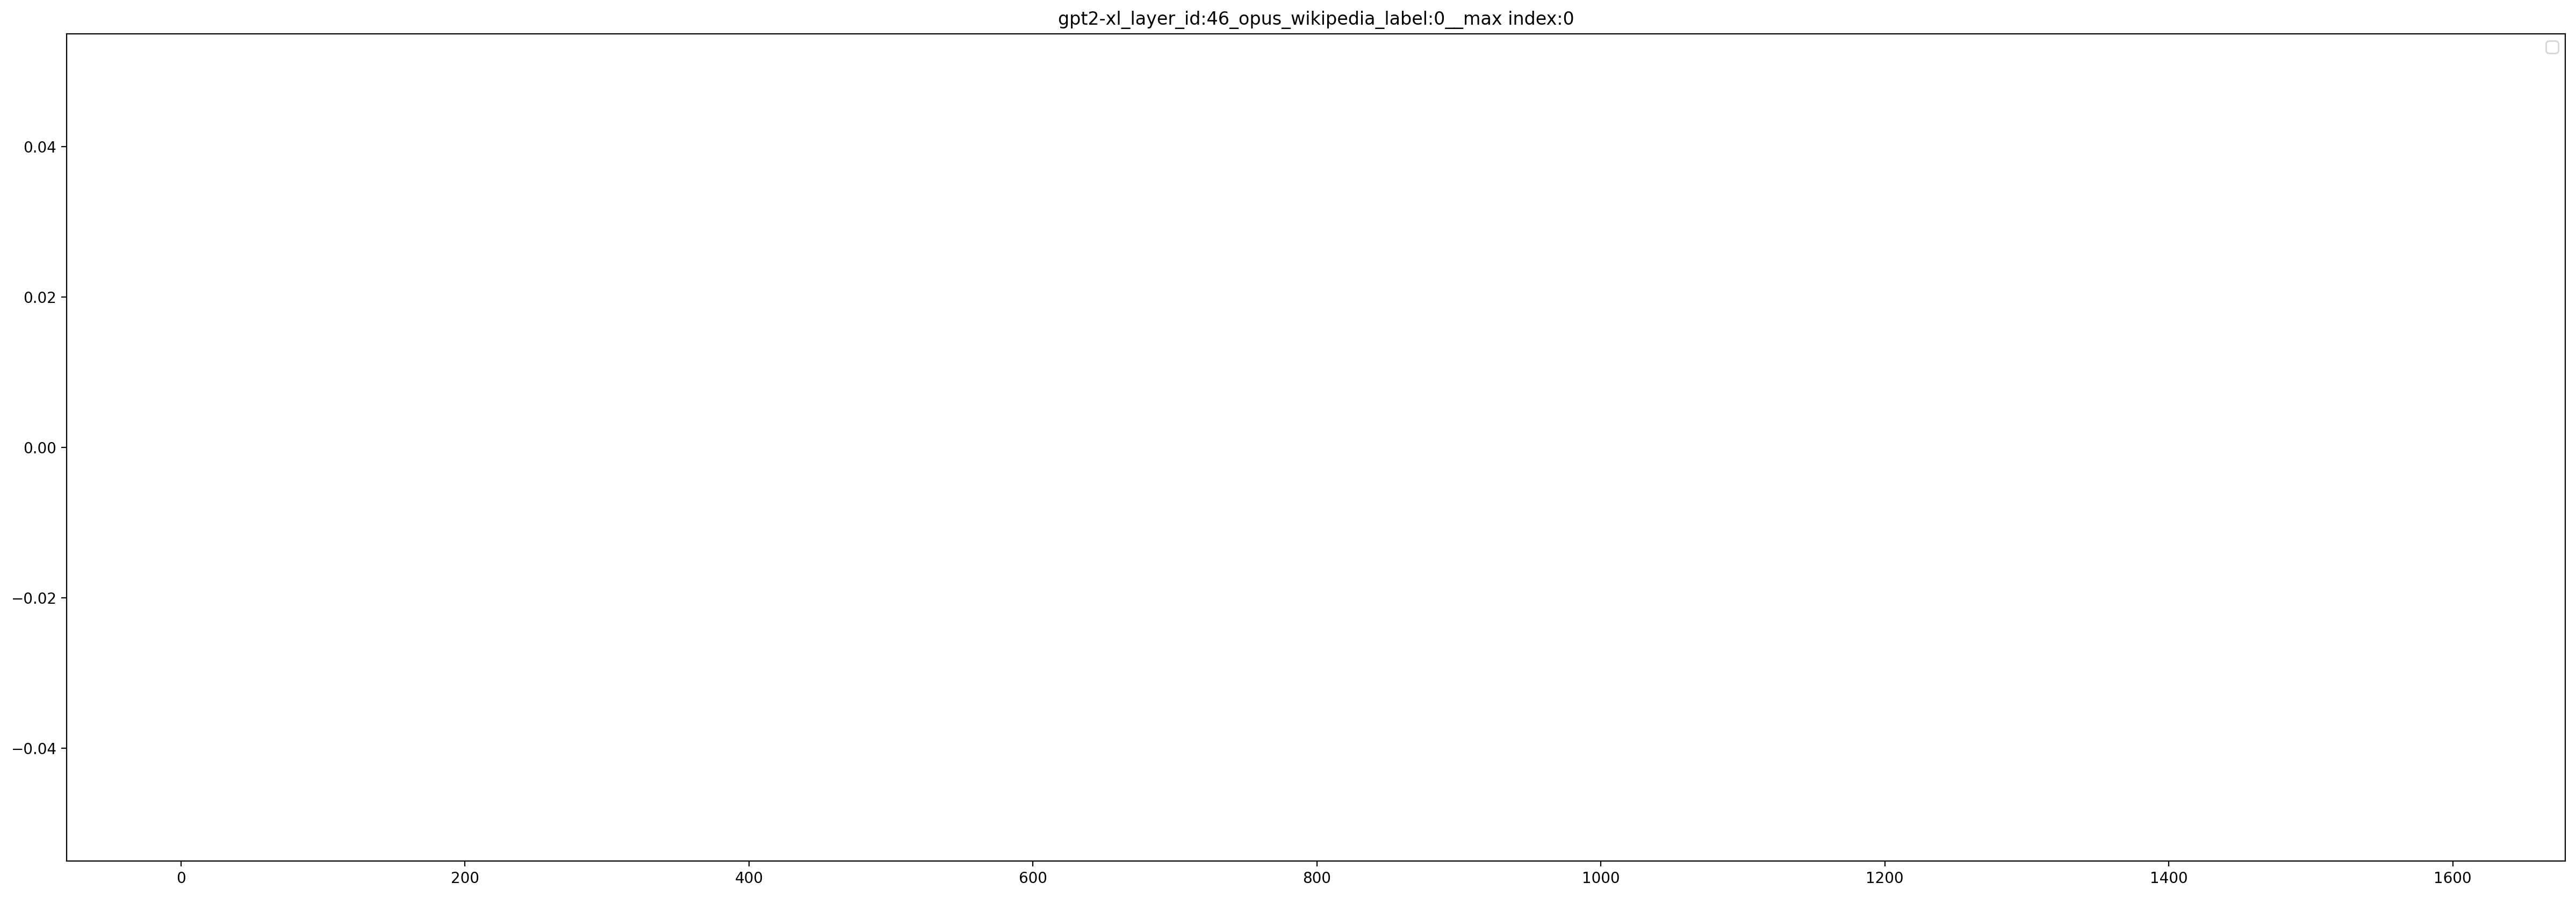

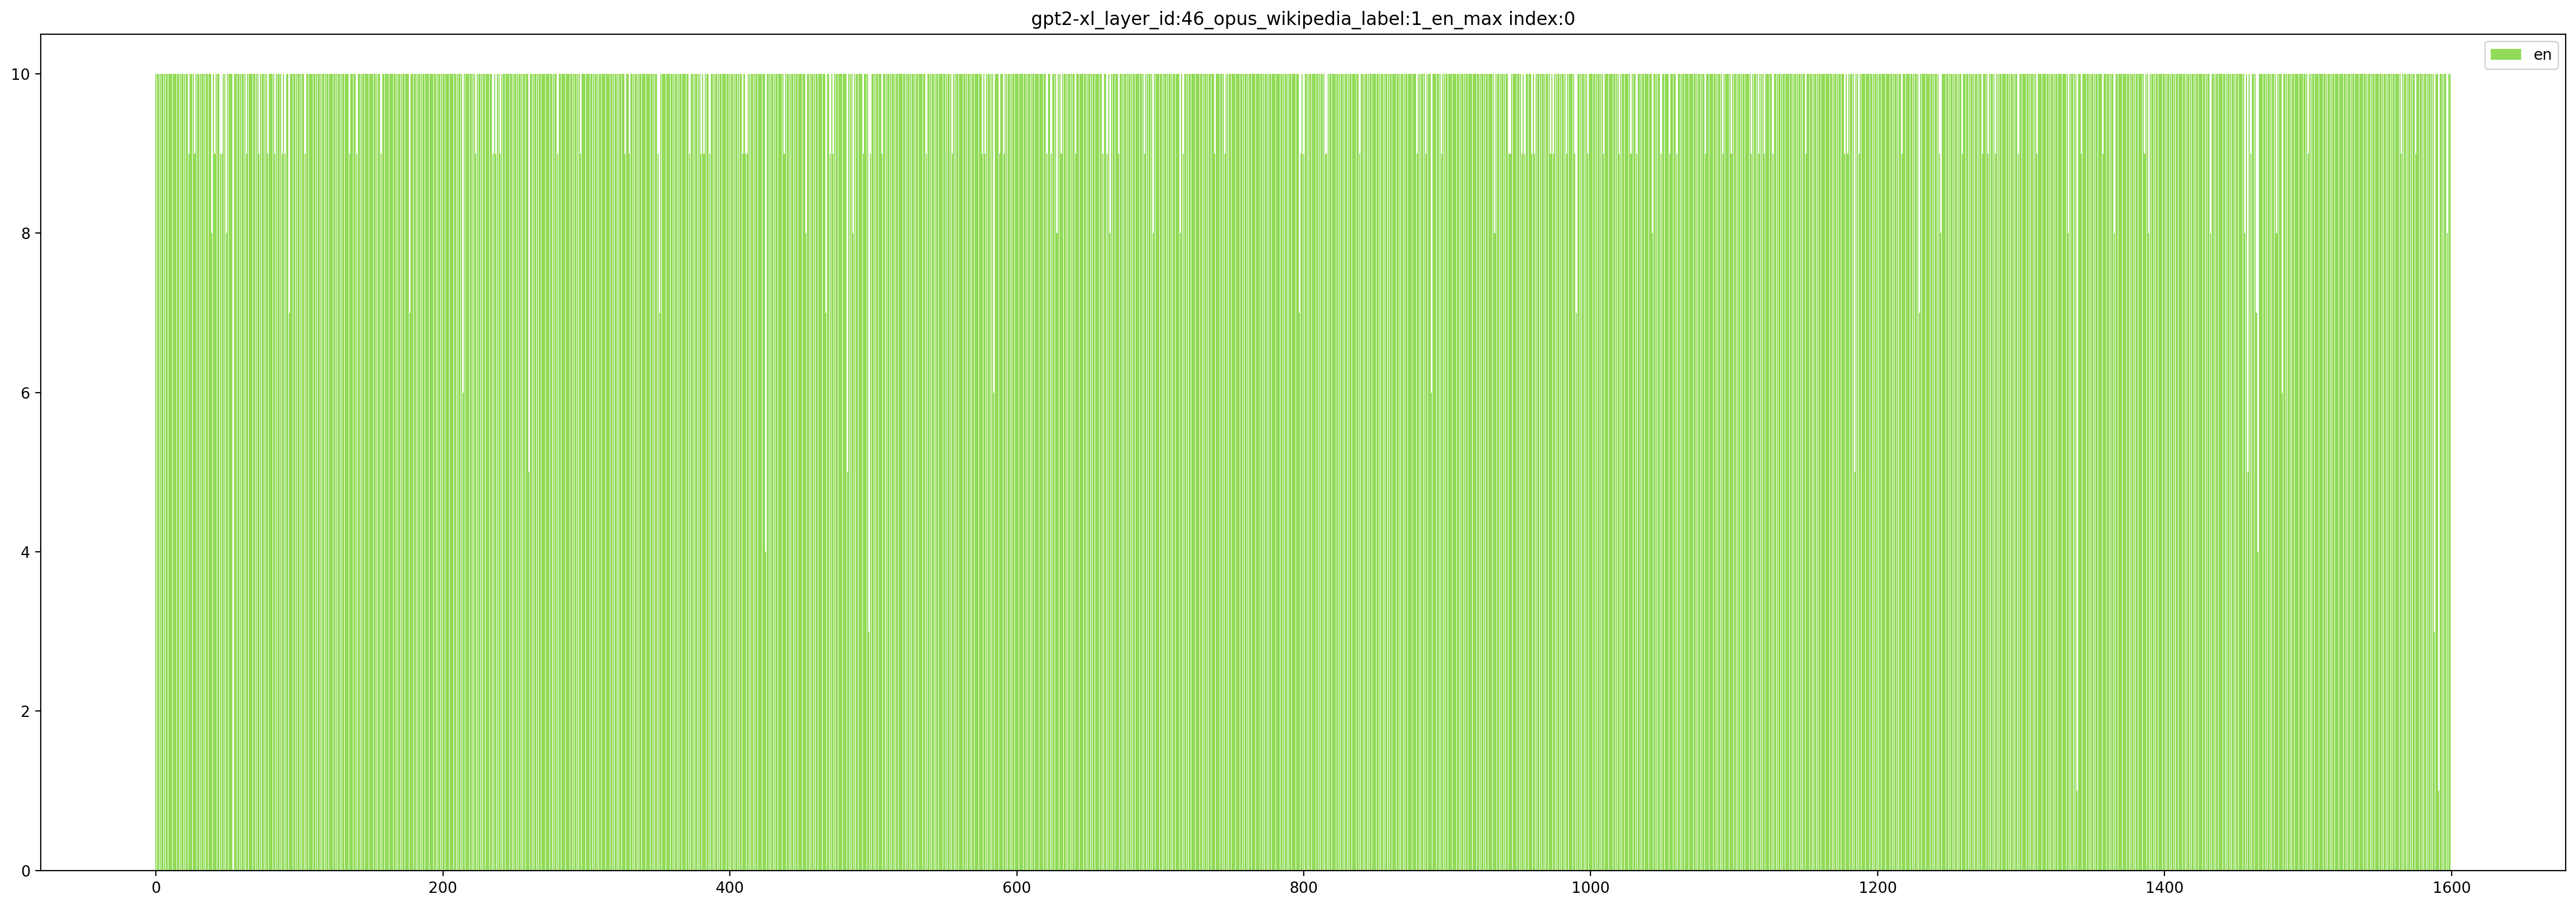

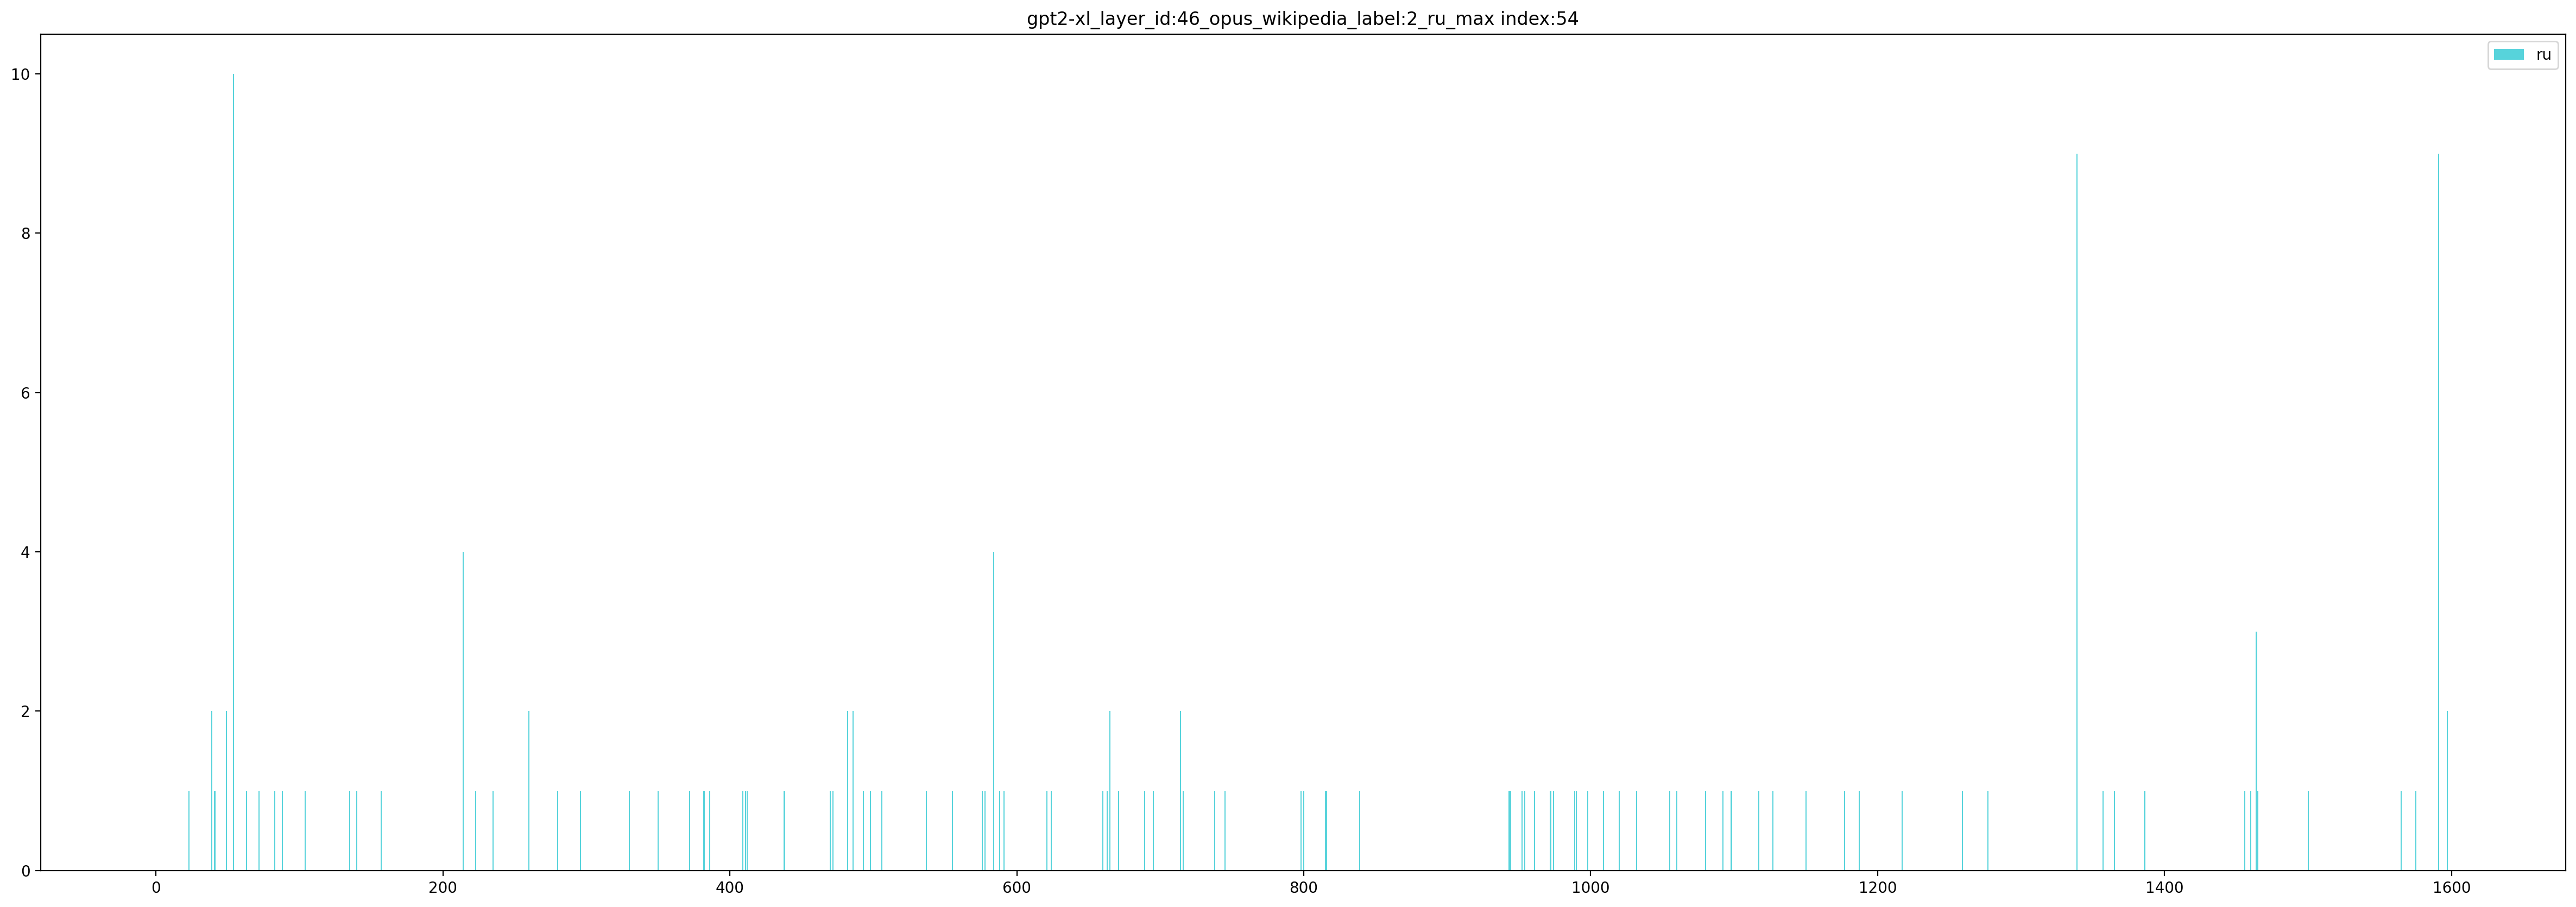

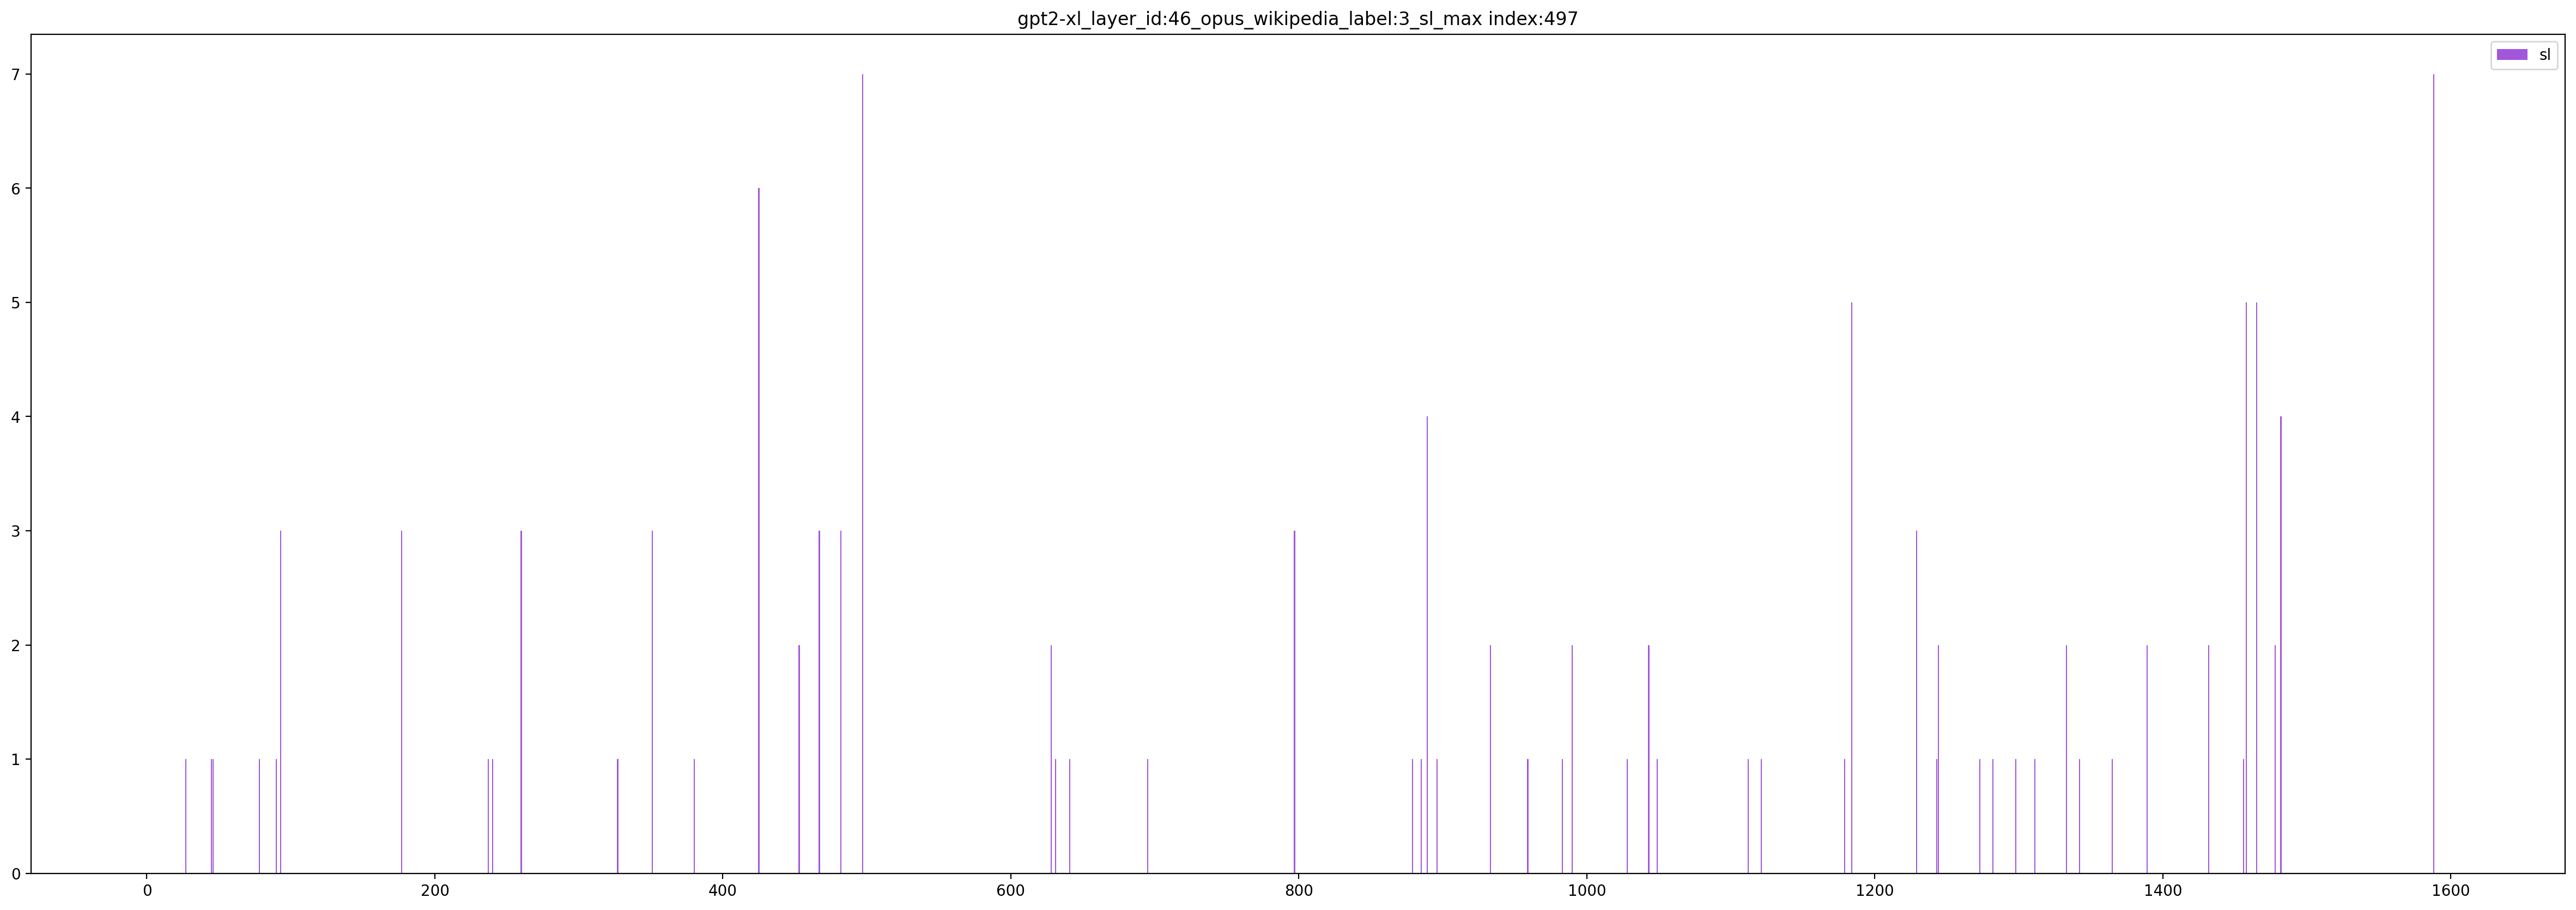

In [10]:
pd_index = range(0, top_k)
top = results[:, :top_k]
top_text = [text_list[i][:top_k] for i in range(len(text_list))]
result_top_pd, text_top_pd, max_index_list = plot_socre_label(results, top, top_text, dirs, datalabel, pd_index, title)

In [ ]:
max_index_list,datalabel
result_top_pd.iloc[max_index_list]
text_top_pd.iloc[max_index_list]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


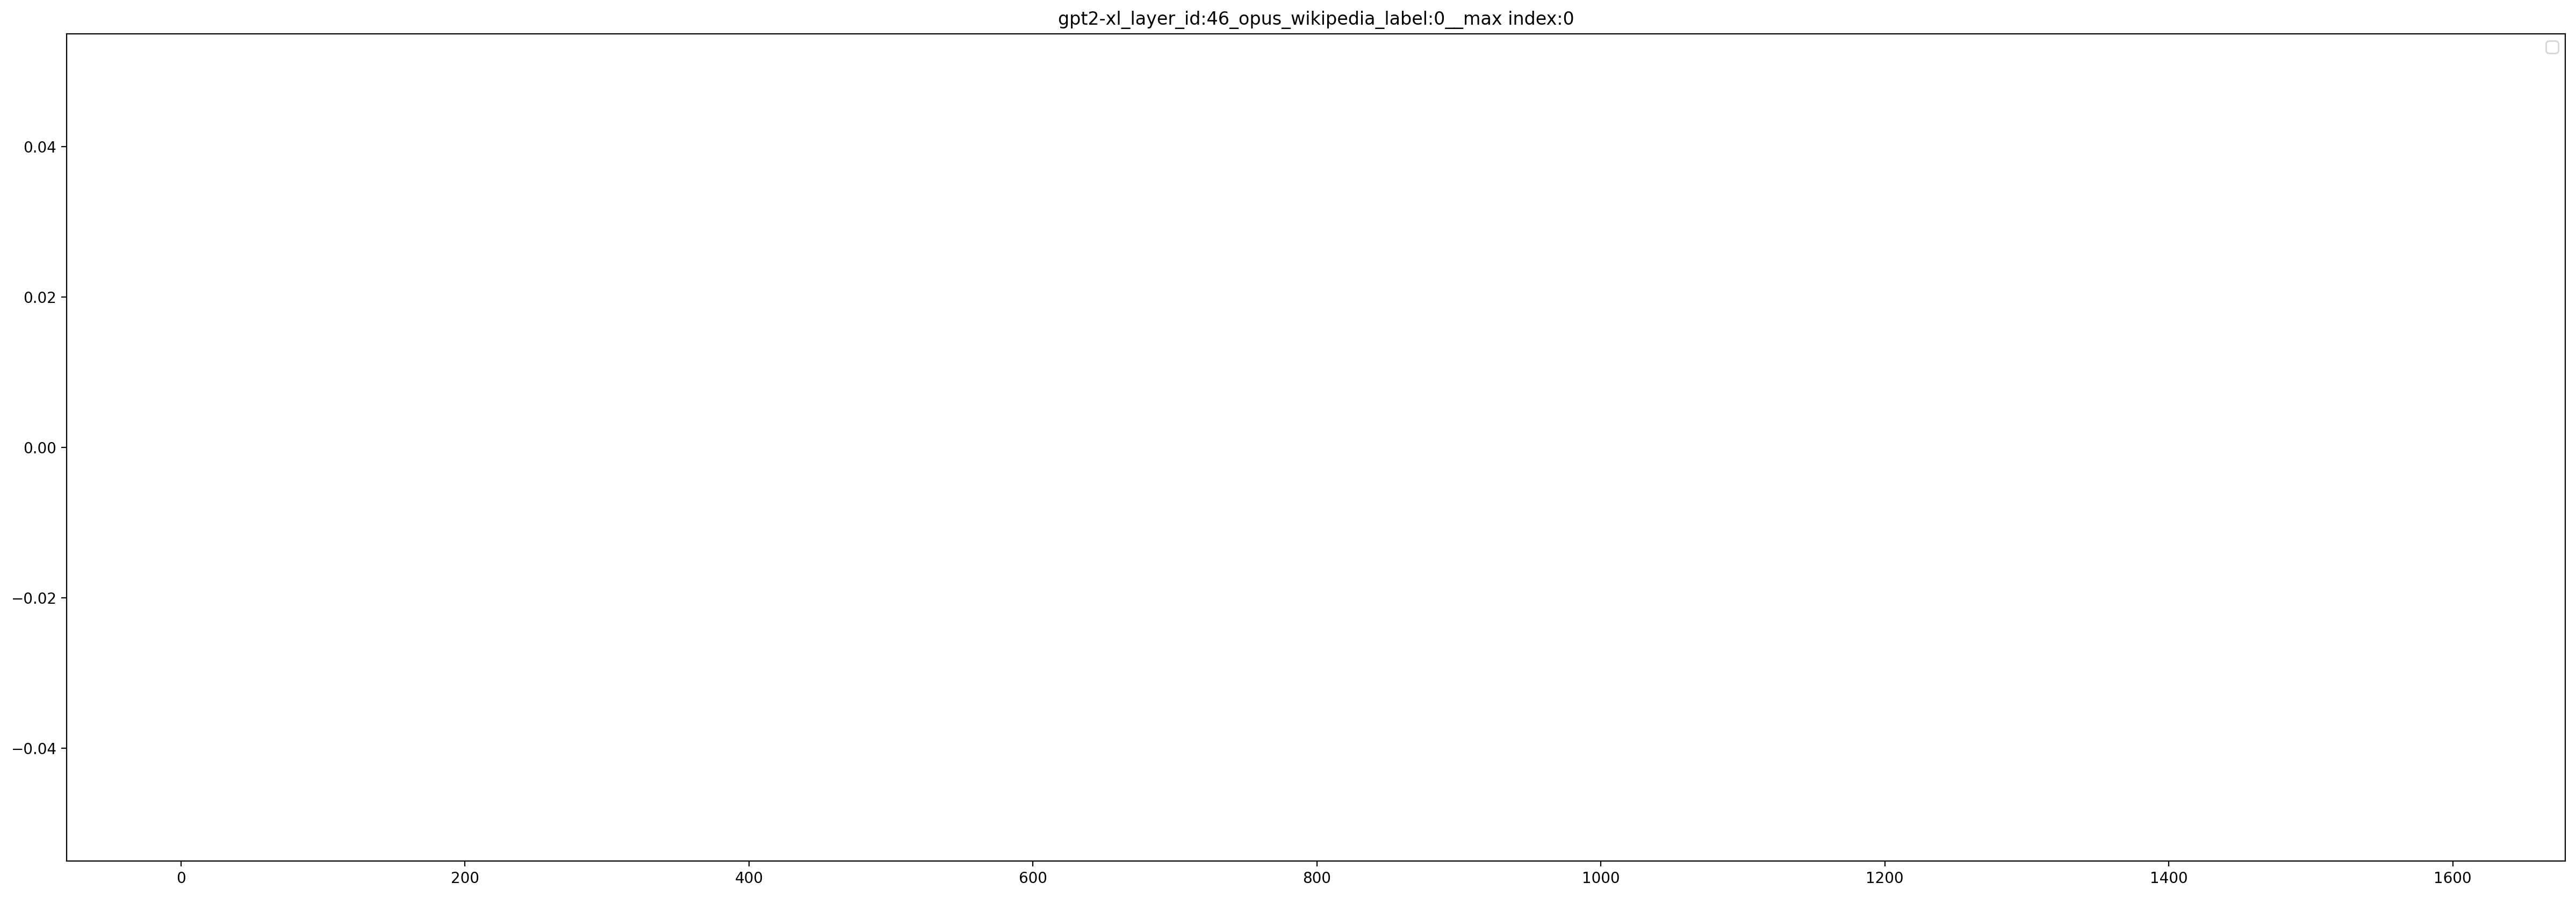

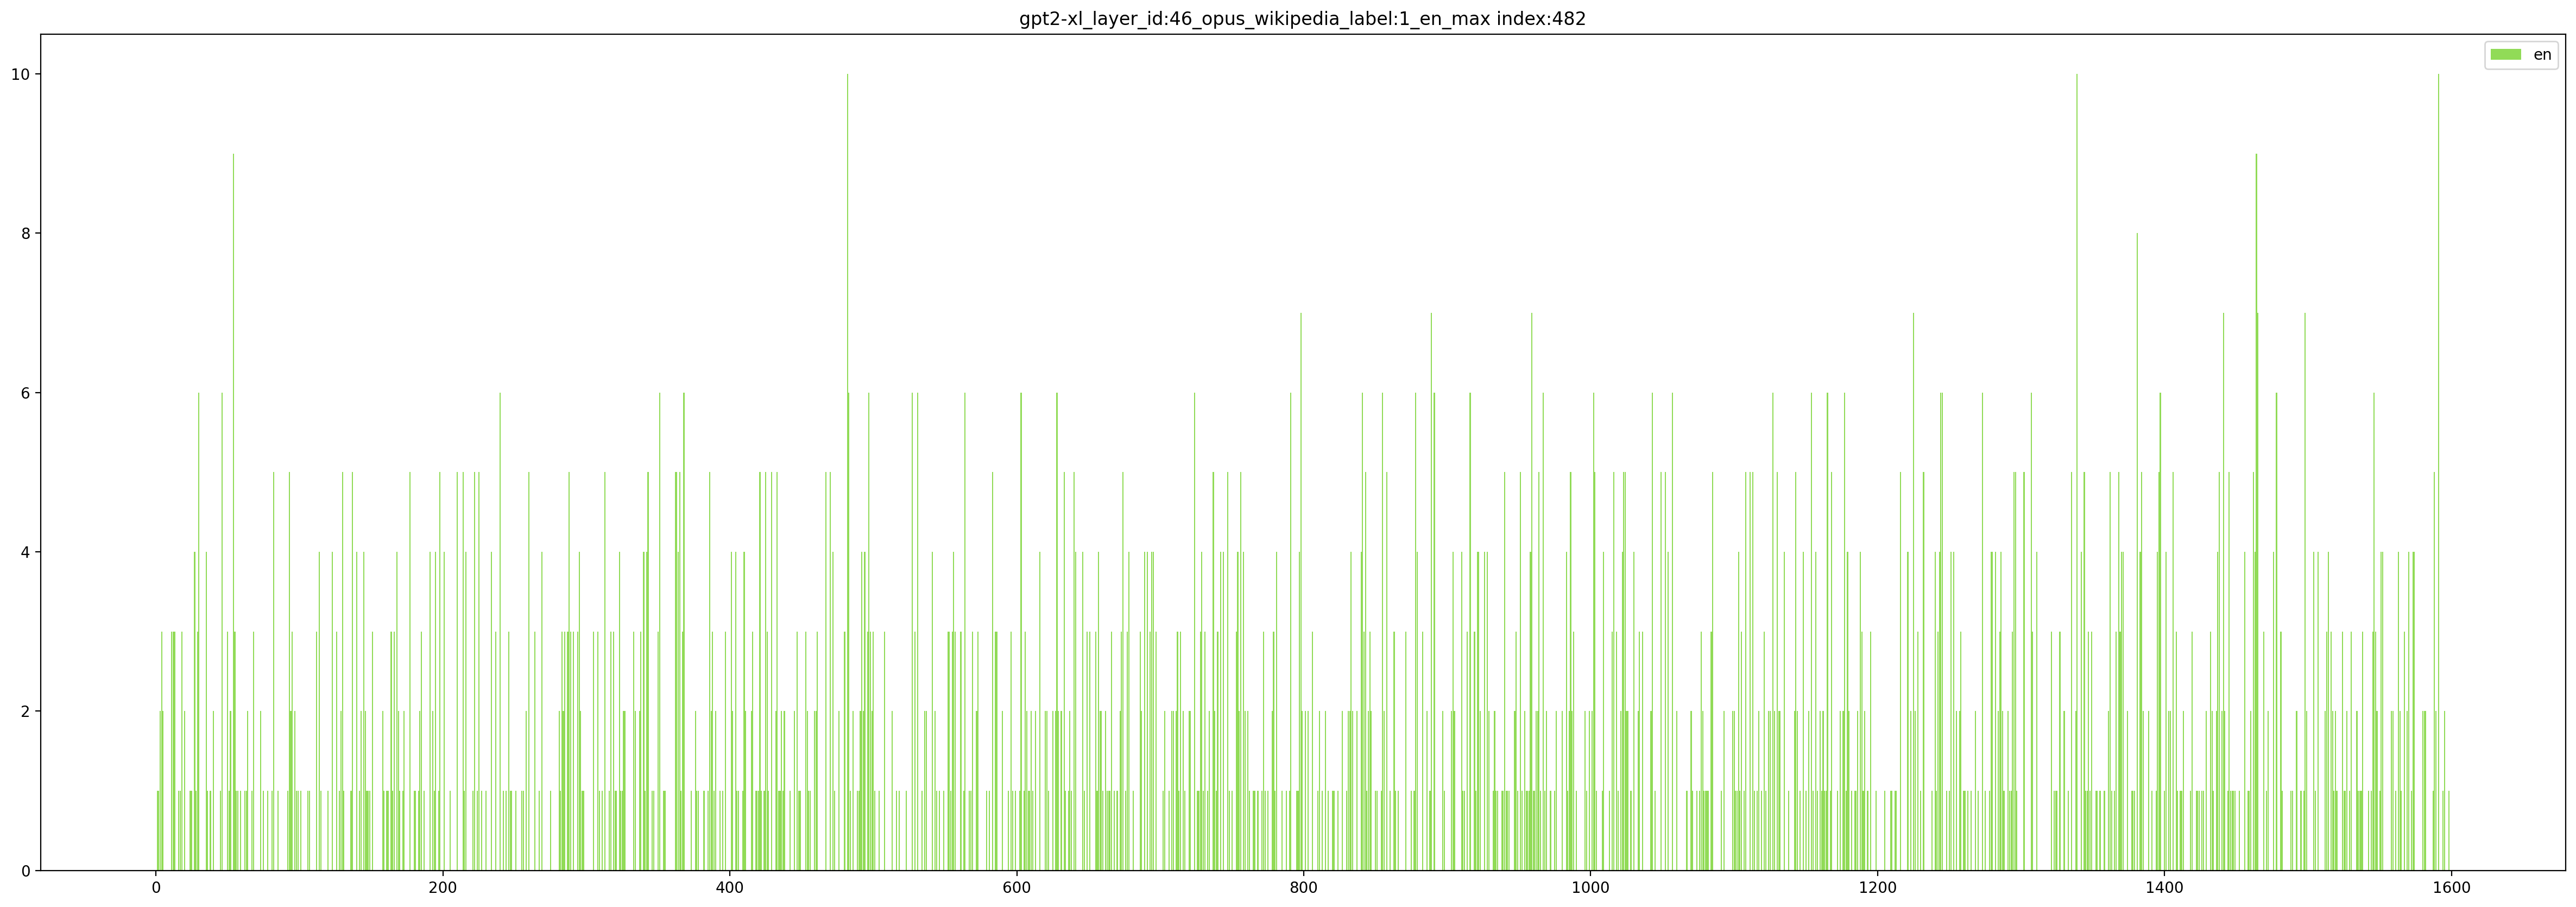

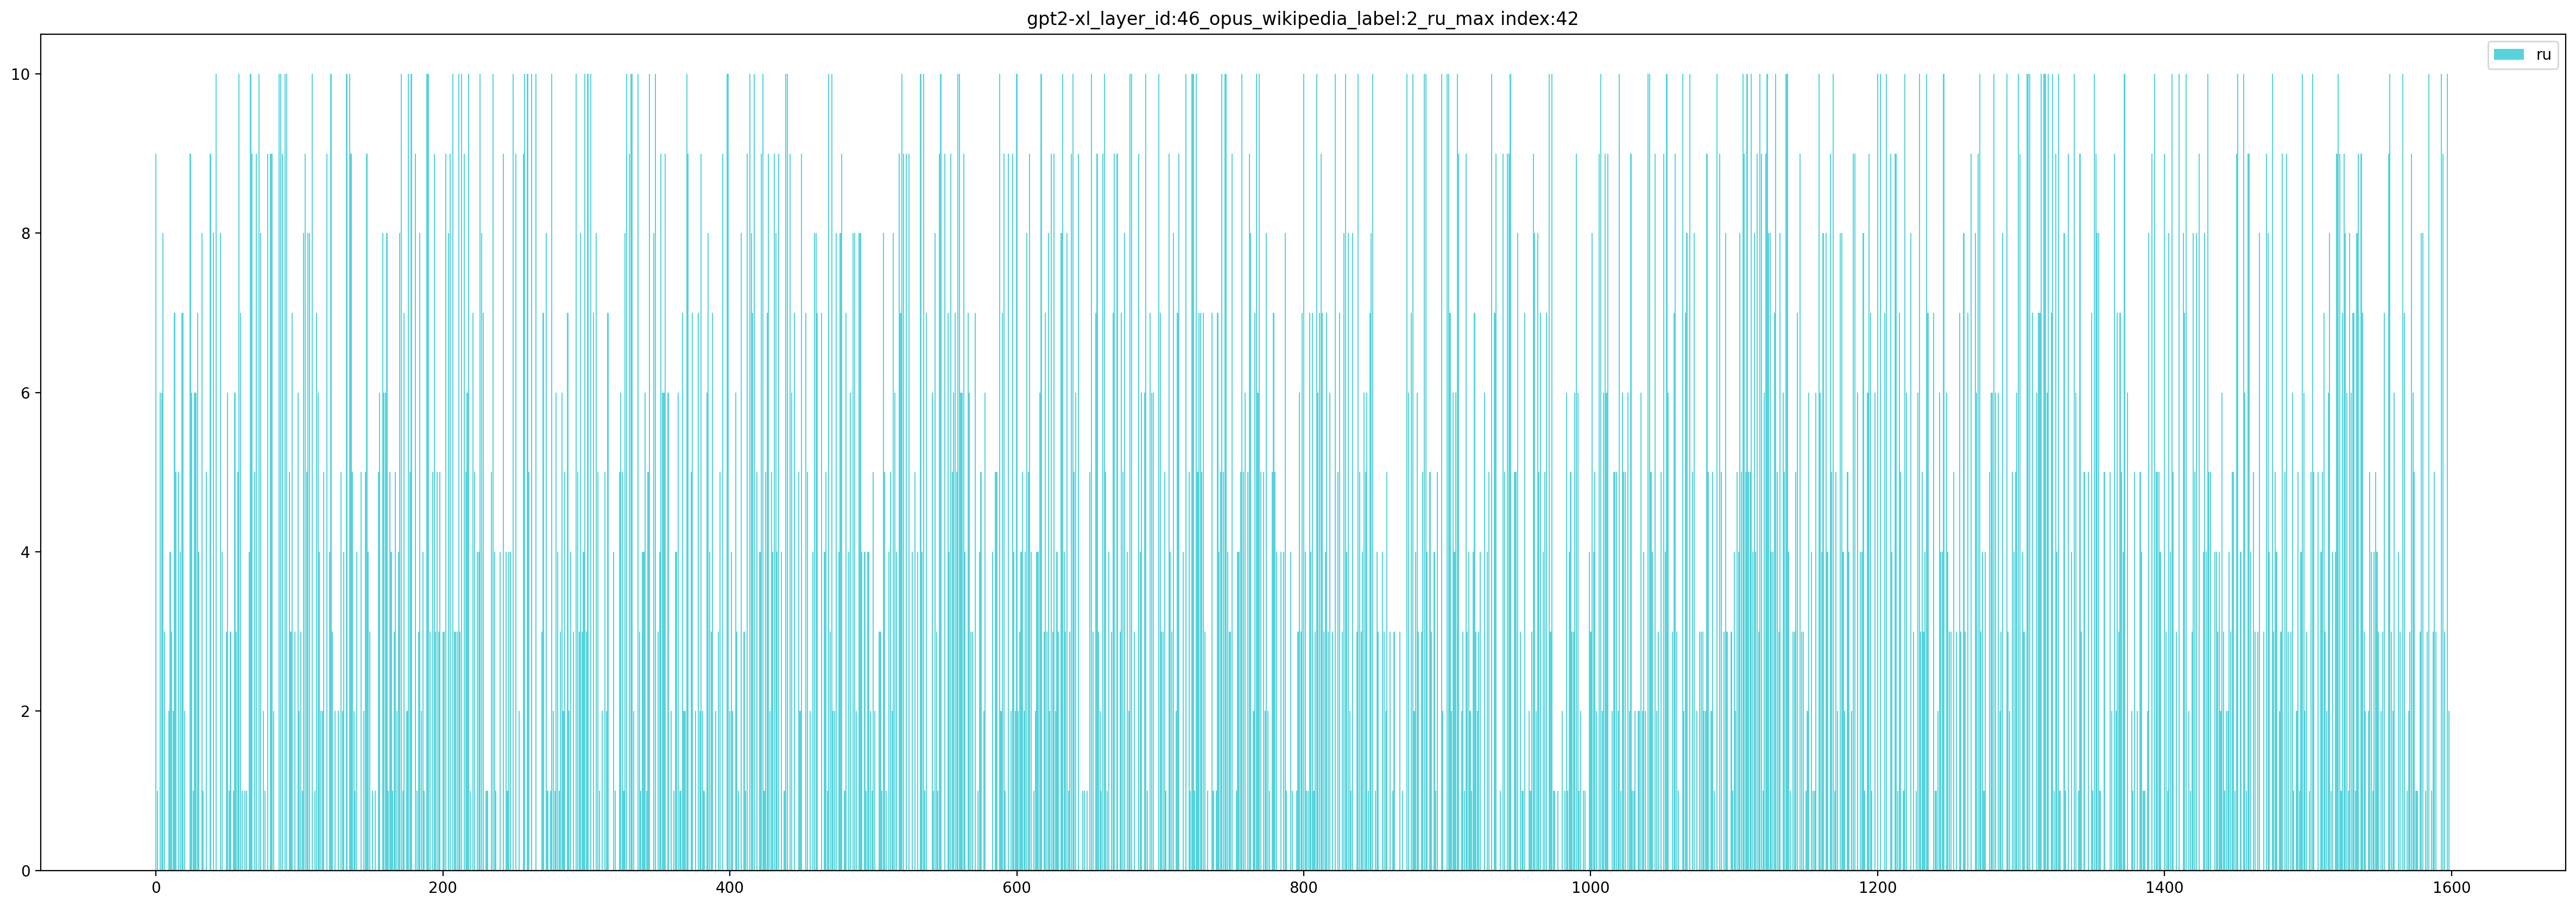

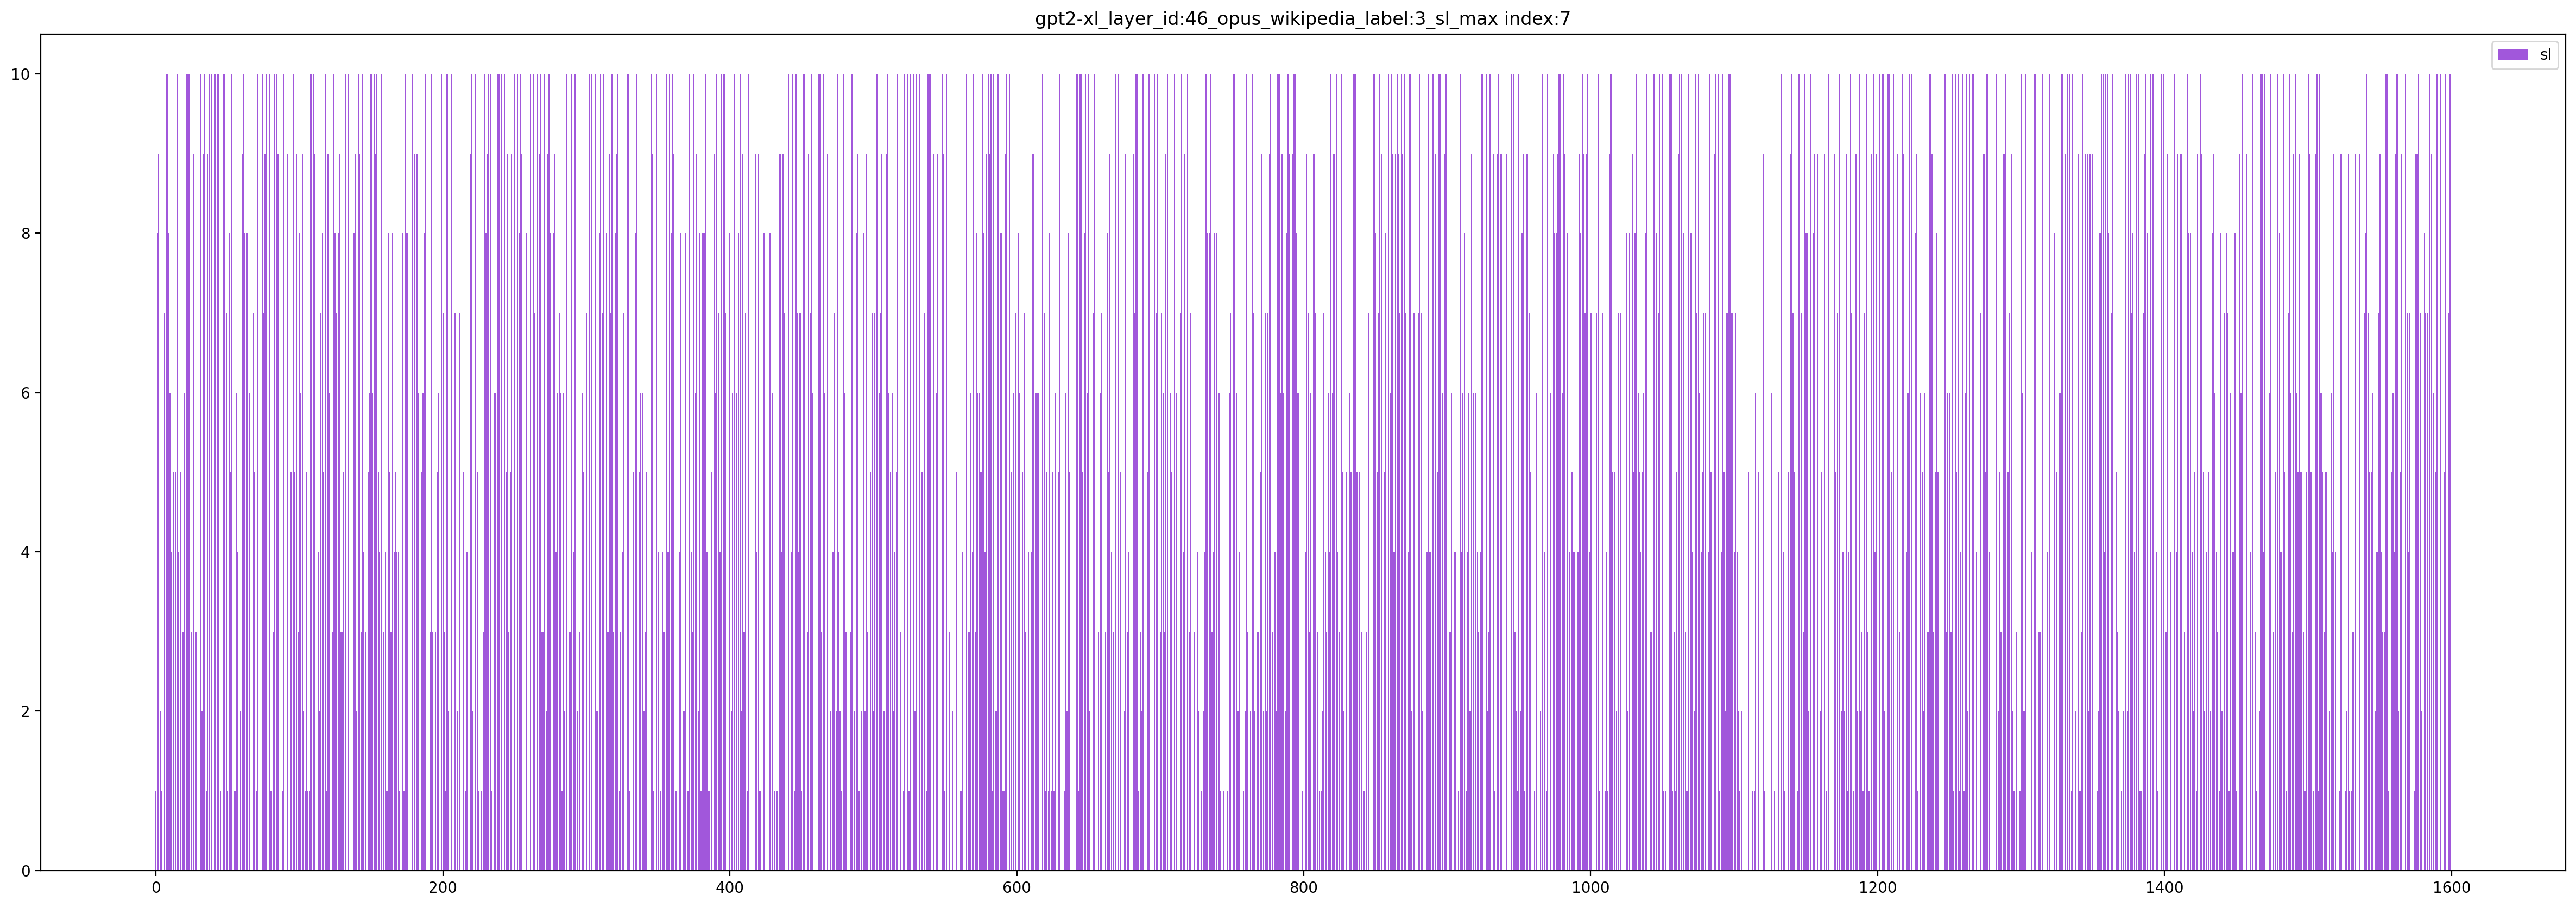

In [11]:
pd_index = range(results.shape[1] - top_k, results.shape[1])
top = results[:, -top_k:]
top_text = [text_list[i][-top_k:] for i in range(len(text_list))]
result_last_pd, text_last_pd, last_index_list = plot_socre_label(results, top, top_text, dirs, datalabel, pd_index, title)

In [ ]:
last_index_list,datalabel
result_last_pd.iloc[max_index_list]
text_last_pd.iloc[max_index_list]

## draw common

[(1, 'en', array([0., 0., 0., ..., 1., 0., 0.]), array([0.        , 0.        , 0.        , ..., 0.        , 0.05882353,
       0.        ])), (2, 'ru', array([0., 0., 0., ..., 1., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])), (3, 'sl', array([0., 0., 0., ..., 1., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]))]


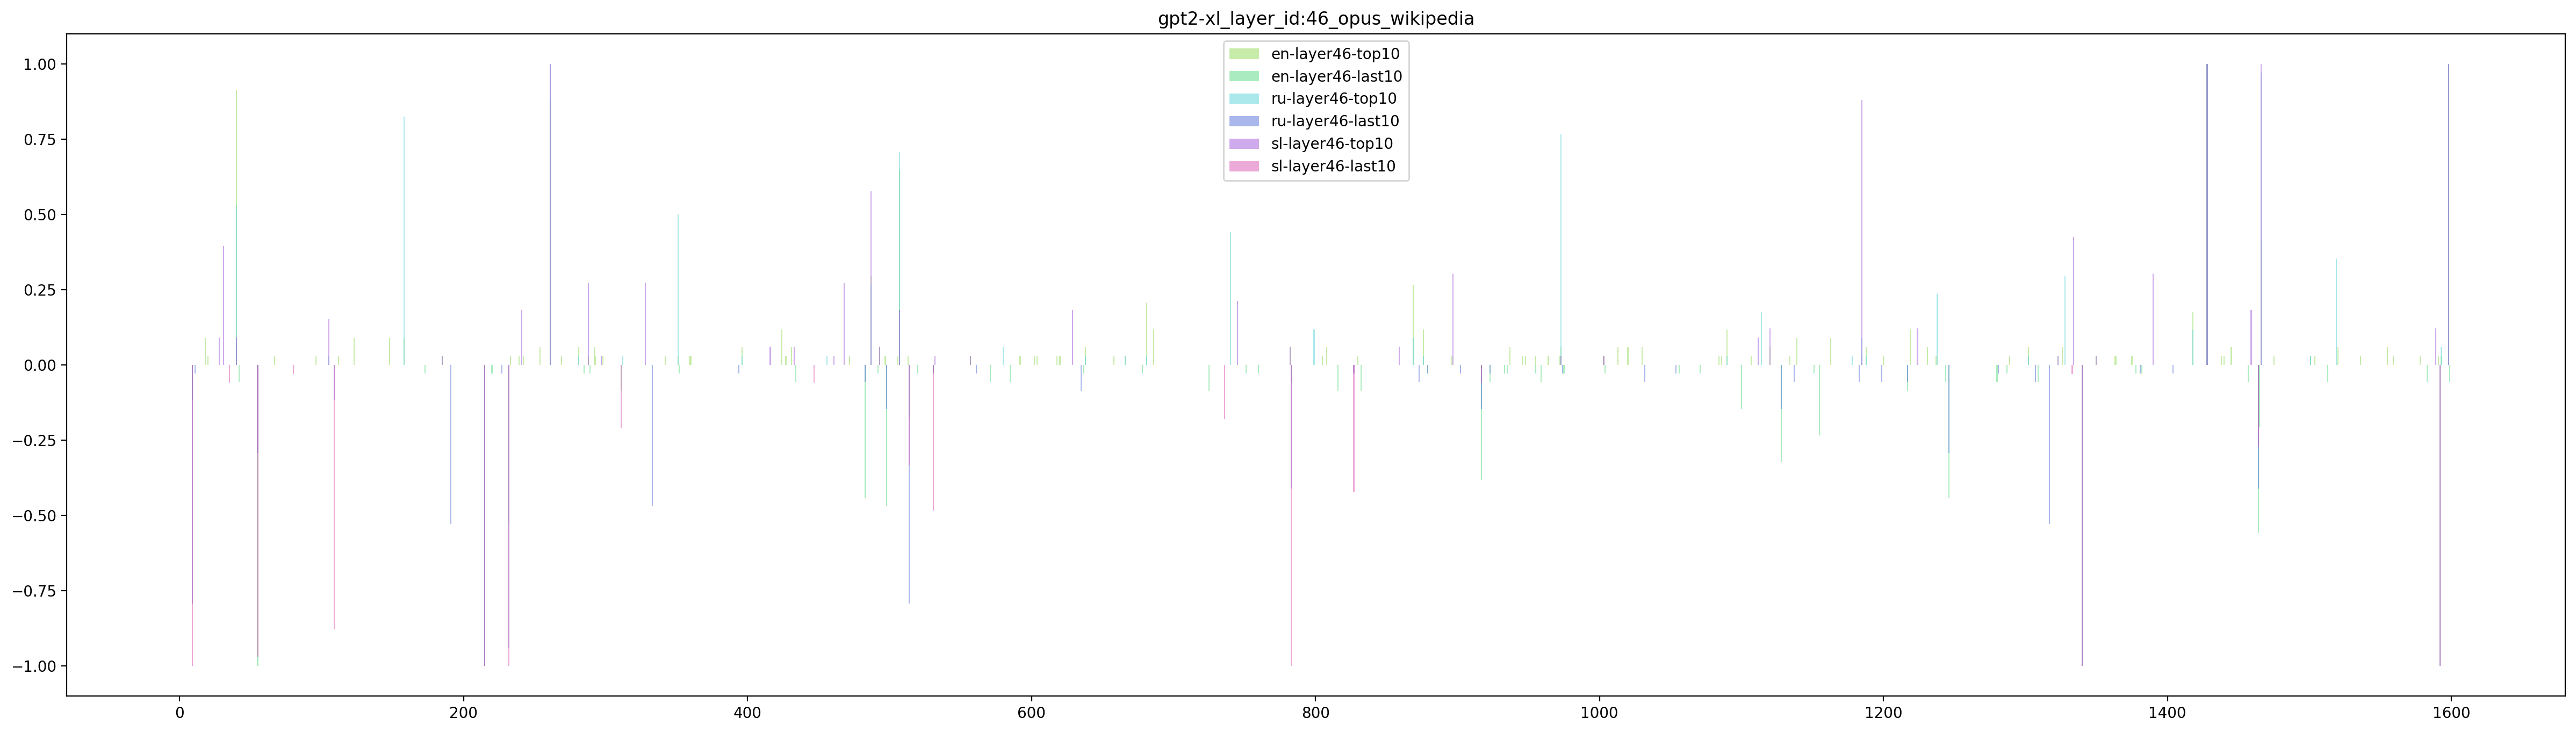

In [12]:
d = module_keys[key_]
activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
# construct dataframe
unit_num = activations.shape[-1]
sentence_num = activations.shape[0]
data_pd = pd.DataFrame(activations,
             index=[f"sentence{i}" for i in range(sentence_num)],
             columns=[f"unit{i}" for i in range(unit_num)])
data_pd['label'] = d['label']

# draw common
stat = plot_common_max_min(data_pd, layer_id, top_k, datalabel, title, dir_path)
print(stat)

In [13]:
standard_top, standard_last = 0.8, 0.8
label_i, label_name, stat_top, stat_last = stat[1]
top_index = np.nonzero(stat_top>standard_top)
last_index = np.nonzero(stat_last>standard_last)
print(f'{label_name}:{datalabel}')

ru:['', 'en', 'ru', 'sl']


In [14]:
result_top_pd.iloc[top_index]

0  1  2  3  4  5  6  7  8  9
157   1  1  1  1  1  1  1  2  1  1
260   1  2  1  1  1  2  1  3  3  3
1427  1  1  1  1  1  1  1  1  1  1
1465  1  3  1  1  1  2  3  3  3  3
1597  1  1  1  2  1  1  1  1  2  1

In [15]:
text_top_pd.iloc[top_index]

0  \
157   The Church of the Tithes was chosen as the fir...   
260                                                 ed.   
1427  Unlike the federal subjects, the federal distr...   
1465                                              1994.   
1597                                                ed.   

                                                      1  \
157                                                 ed.   
260                                                д.).   
1427  All of these problems contributed to the popul...   
1465  21. marec je 80. dan leta (81. v prestopnih le...   
1597                                              1967.   

                                                      2  \
157   Linguistics is the scientific study of languag...   
260                                               1967.   
1427       On , a provisional government was announced.   
1465                                              1967.   
1597                                                77.   

                                                      3  \
157   All of these problems contributed to the popul...   
260                                               1994.   
1427  The labor problem began with the industrializa...   
1465                                                77.   
1597                                               д.).   

                                                      4  \
157   St. Mary, St. Nicholas, St. Andrew, St. George...   
260                                                 77.   
1427  Durkheim maintained that the social sciences a...   
1465                                              2004.   
1597  Durkheim maintained that the social sciences a...   

                                                      5  \
157   At the beginning of the 19th century, the Russ...   
260                                               2004.   
1427  Linguistics is the scientific study of languag...   
1465                                              2004.   
1597  Linguistics is the scientific study of languag...   

                                                      6  \
157   The labor problem began with the industrializa...   
260                                               2004.   
1427  73% of the population lives in urban areas whi...   
1465  9. marec je 68. dan leta (69. v prestopnih let...   
1597                                              1994.   

                                                      7  \
157                                                д.).   
260   : "Glej tudi: število 666"666 (DCLXVI) je bilo...   
1427  Society is nothing more than the shared realit...   
1465  17. julij je 198. dan leta (199. v prestopnih ...   
1597  All of these problems contributed to the popul...   

                                                      8  \
157   An emigration department was created in 1906 a...   
260   17. julij je 198. dan leta (199. v prestopnih ...   
1427  Association football is one of the most popula...   
1465  * 12. februar - Nasina vesoljska sonda NEAR Sh...   
1597                                              2004.   

                                                      9  
157   This all set the stage for the strikes in St. ...  
260   886 (DCCCLXXXVI) je bilo navadno leto, ki se j...  
1427  During the summer, Bolshevik power in Siberia ...  
1465  5. februar je 36. dan leta v gregorijanskem ko...  
1597                                              2004.

In [16]:
result_last_pd.iloc[last_index]

91   92   93   94   95   96   97   98   99   100
214     1    1    1    3    3    3    1    3    3    1
231     3    3    3    2    3    3    3    3    3    3
1339    1    1    1    1    1    1    1    1    1    1
1591    1    1    1    1    1    1    1    1    1    1

In [17]:
text_last_pd.iloc[last_index]

91   \
214   This all set the stage for the strikes in St. ...   
231   886 (DCCCLXXXVI) je bilo navadno leto, ki se j...   
1339  Durkheim maintained that the social sciences a...   
1591  Association football is one of the most popula...   

                                                    92   \
214   The February Revolution () of 1917 was the fir...   
231   886 (DCCCLXXXVI) je bilo navadno leto, ki se j...   
1339                                History of Ukraine.   
1591  The Church of the Tithes was chosen as the fir...   

                                                    93   \
214        On , a provisional government was announced.   
231   21. marec je 80. dan leta (81. v prestopnih le...   
1339                                                ed.   
1591       On , a provisional government was announced.   

                                                    94   \
214   Na materino vztrajanje se je učil igrati violino.   
231   Российская империя была третьим по площади из ...   
1339  Unlike the federal subjects, the federal distr...   
1591  All of these problems contributed to the popul...   

                                                    95   \
214   Einstein se je začel učiti matematike pri prib...   
231   9. marec je 68. dan leta (69. v prestopnih let...   
1339       On , a provisional government was announced.   
1591  In March 2004, Lithuania became a full member ...   

                                                    96   \
214   Še pred koncem šolskega leta je odpotoval, ne ...   
231   Einstein se je začel učiti matematike pri prib...   
1339  During the summer, Bolshevik power in Siberia ...   
1591  In March 2004, Lithuania became a full member ...   

                                                    97   \
214   An emigration department was created in 1906 a...   
231   Te reči imenujemo elementi in jih med seboj lo...   
1339  73% of the population lives in urban areas whi...   
1591                                History of Ukraine.   

                                                    98   \
214   Leto je bilo proglašeno za Mednarodno leto sla...   
231                        * Obstaja naravno število 0.   
1339  The labor problem began with the industrializa...   
1591  The labor problem began with the industrializa...   

                                                    99   \
214   Te reči imenujemo elementi in jih med seboj lo...   
231   Še pred koncem šolskega leta je odpotoval, ne ...   
1339  An emigration department was created in 1906 a...   
1591                                                ed.   

                                                    100  
214   During the summer, Bolshevik power in Siberia ...  
231   : "Glej tudi: število 666"666 (DCLXVI) je bilo...  
1339  All of these problems contributed to the popul...  
1591  During the summer, Bolshevik power in Siberia ...

## draw umap

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

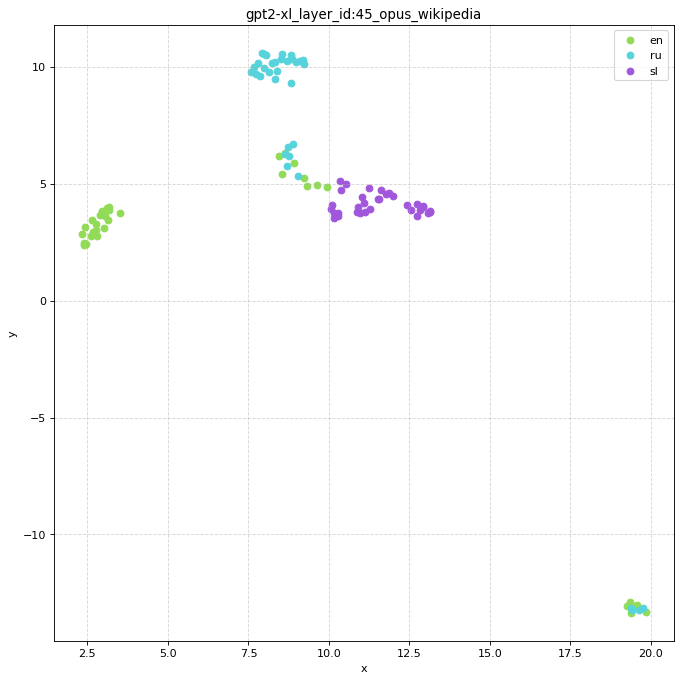

In [18]:
# draw umap
layer_id = 45
activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
y_array = np.array(d['label'])
title = f"{model_name}_layer_id:{layer_id}_{dataset_dict[key]}"
plot_umap(activations, y_array, datalabel, title, dir_path)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

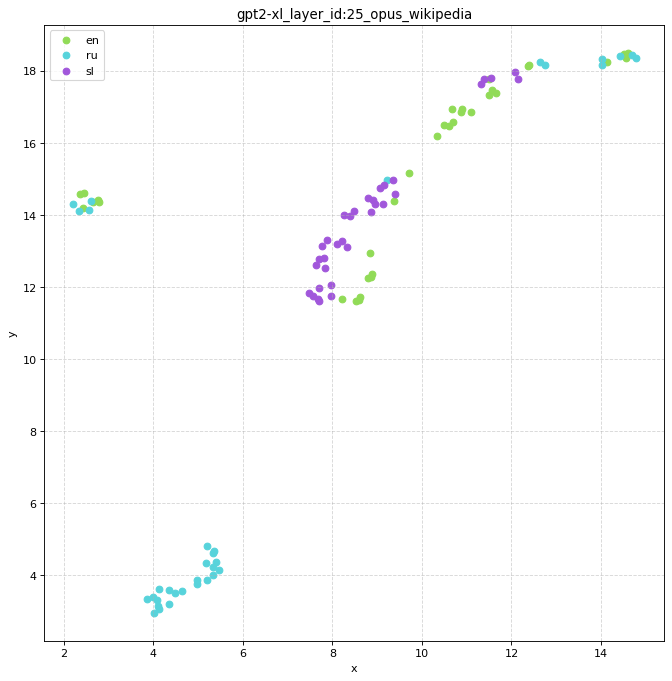

In [19]:
# draw umap
layer_id = 25
activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
y_array = np.array(d['label'])
title = f"{model_name}_layer_id:{layer_id}_{dataset_dict[key]}"
datalabel = datalabels[key]
plot_umap(activations, y_array, datalabel, title, dir_path)

## draw score values

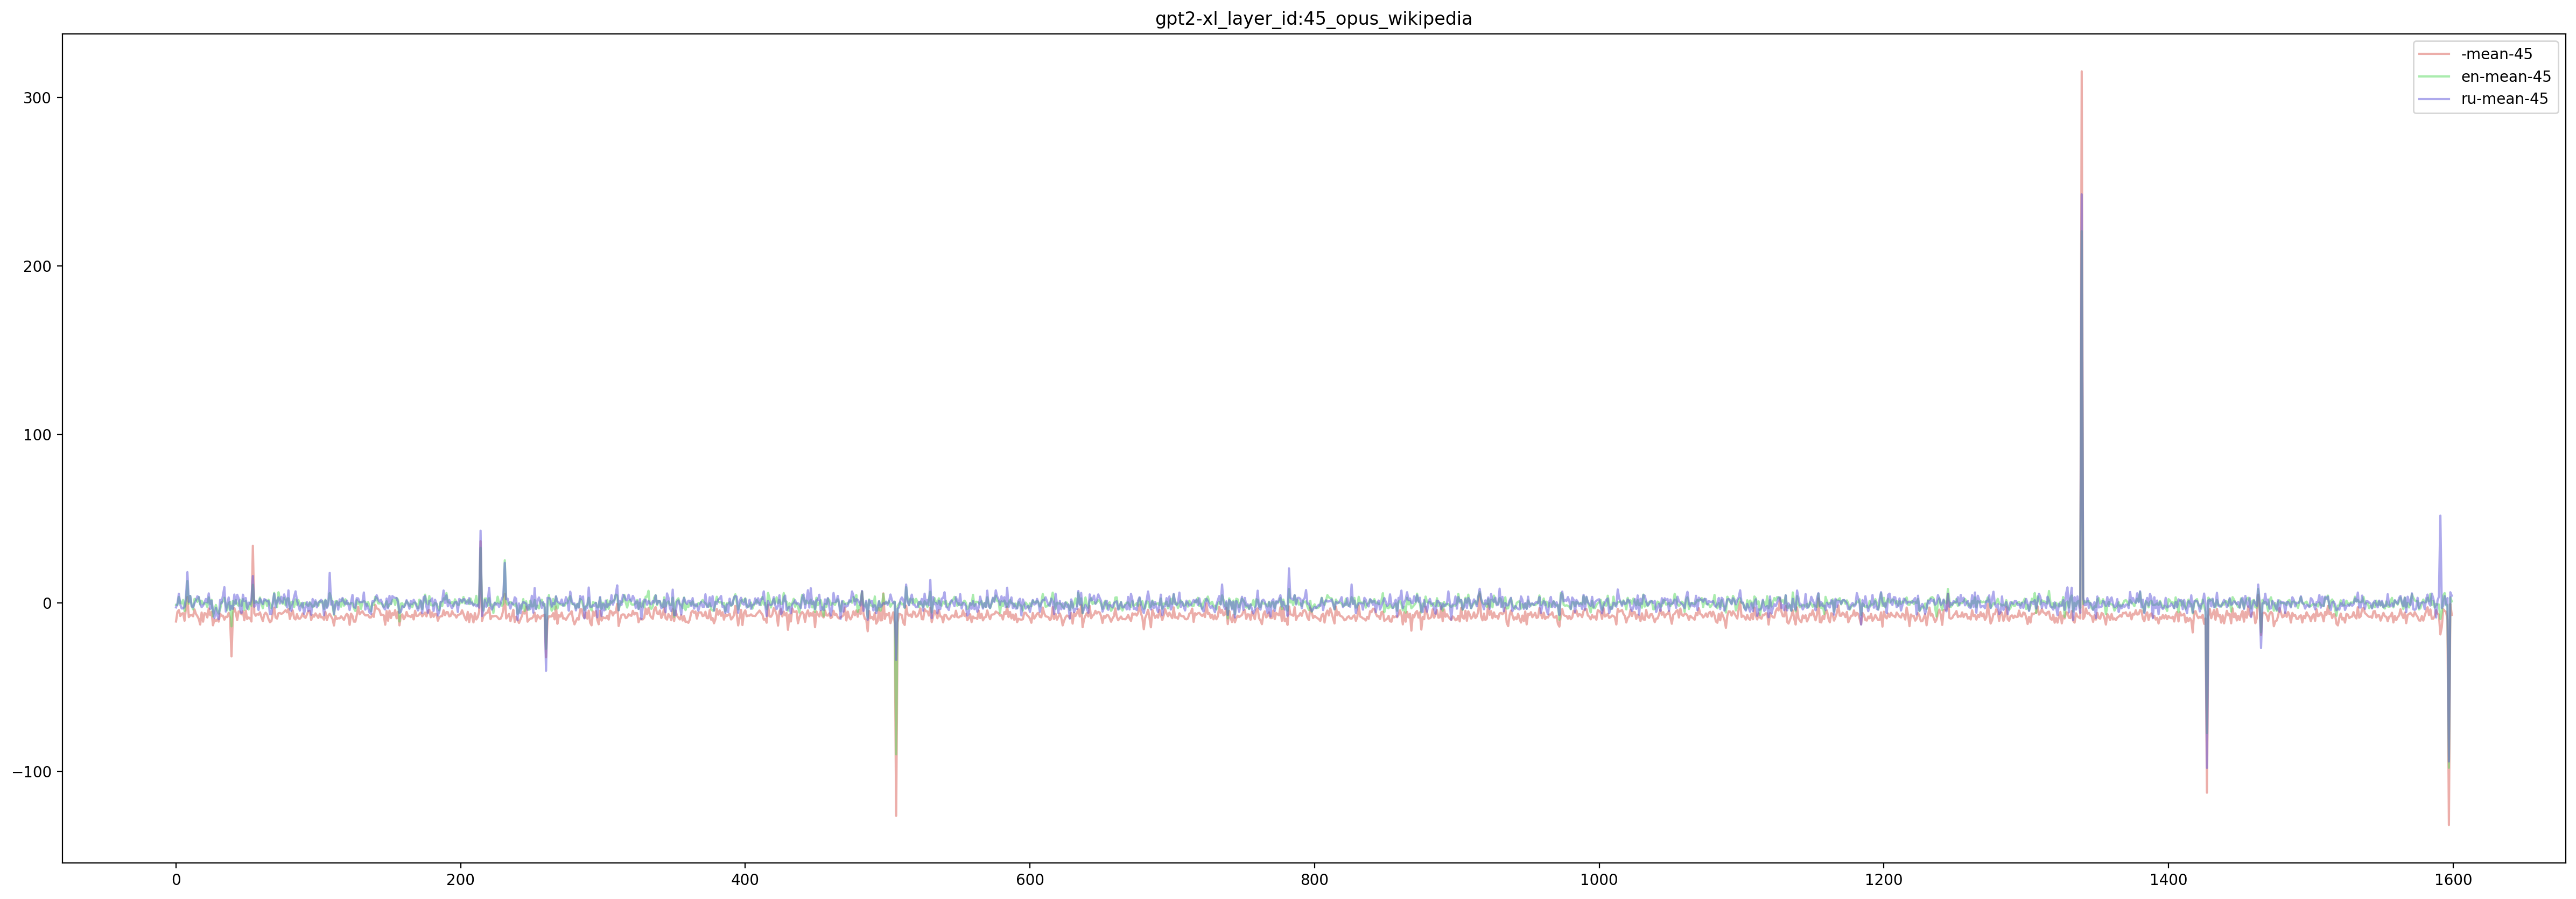

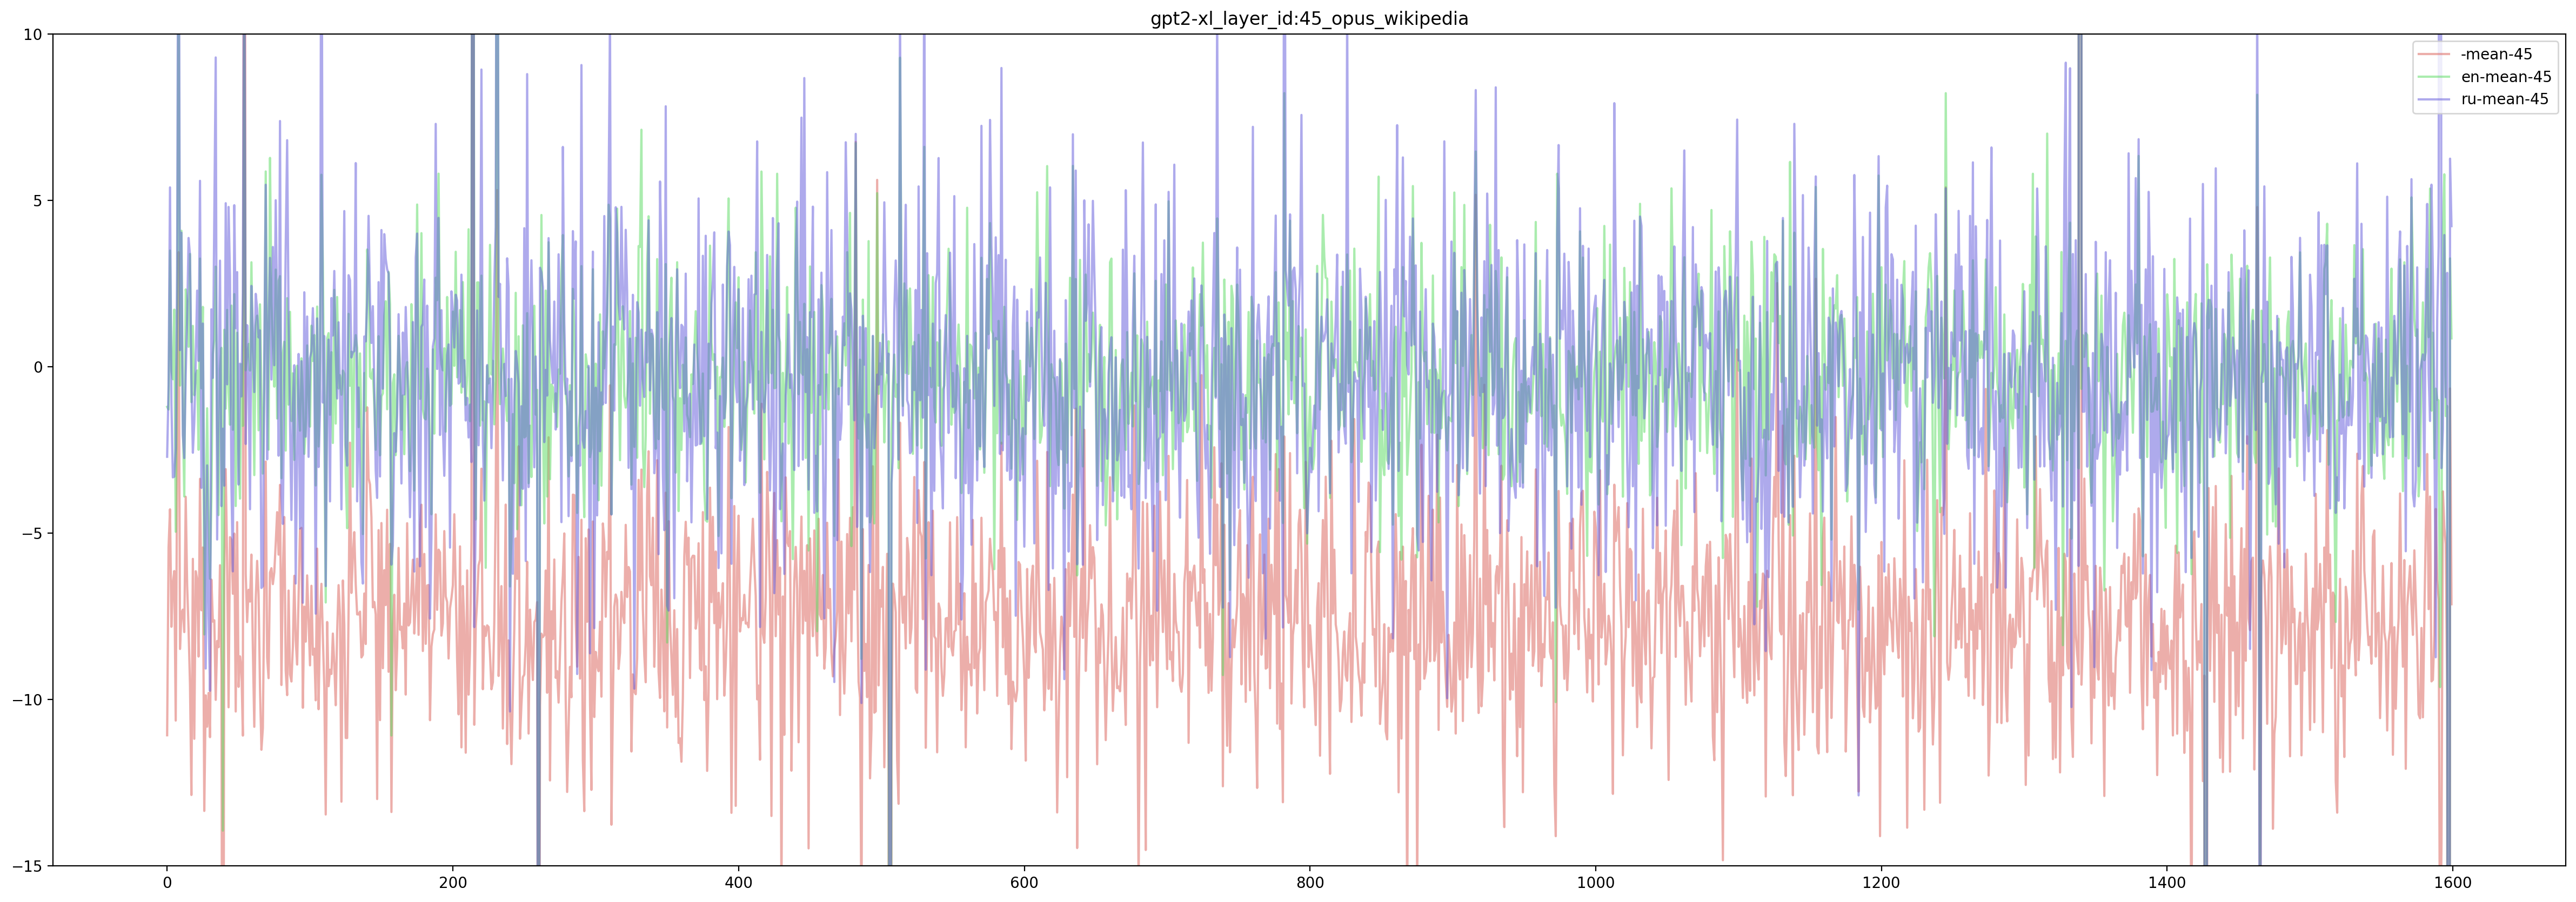

In [20]:
layer_id = 45
title = f"{model_name}_layer_id:{layer_id}_{dataset_dict[key]}"

d = module_keys[key_]
activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
# construct dataframe
unit_num = activations.shape[-1]
x = range(unit_num)
data_pd = get_data_pd(d, layer_id)

mean_pd = data_pd.groupby(['label']).mean()
plot_line(x, mean_pd, datalabel, "mean", layer_id, None, title, dir_path, False)
# print(min_pd)
plot_line(x, mean_pd, datalabel, "mean", layer_id, [-15,10], title, dir_path, False)

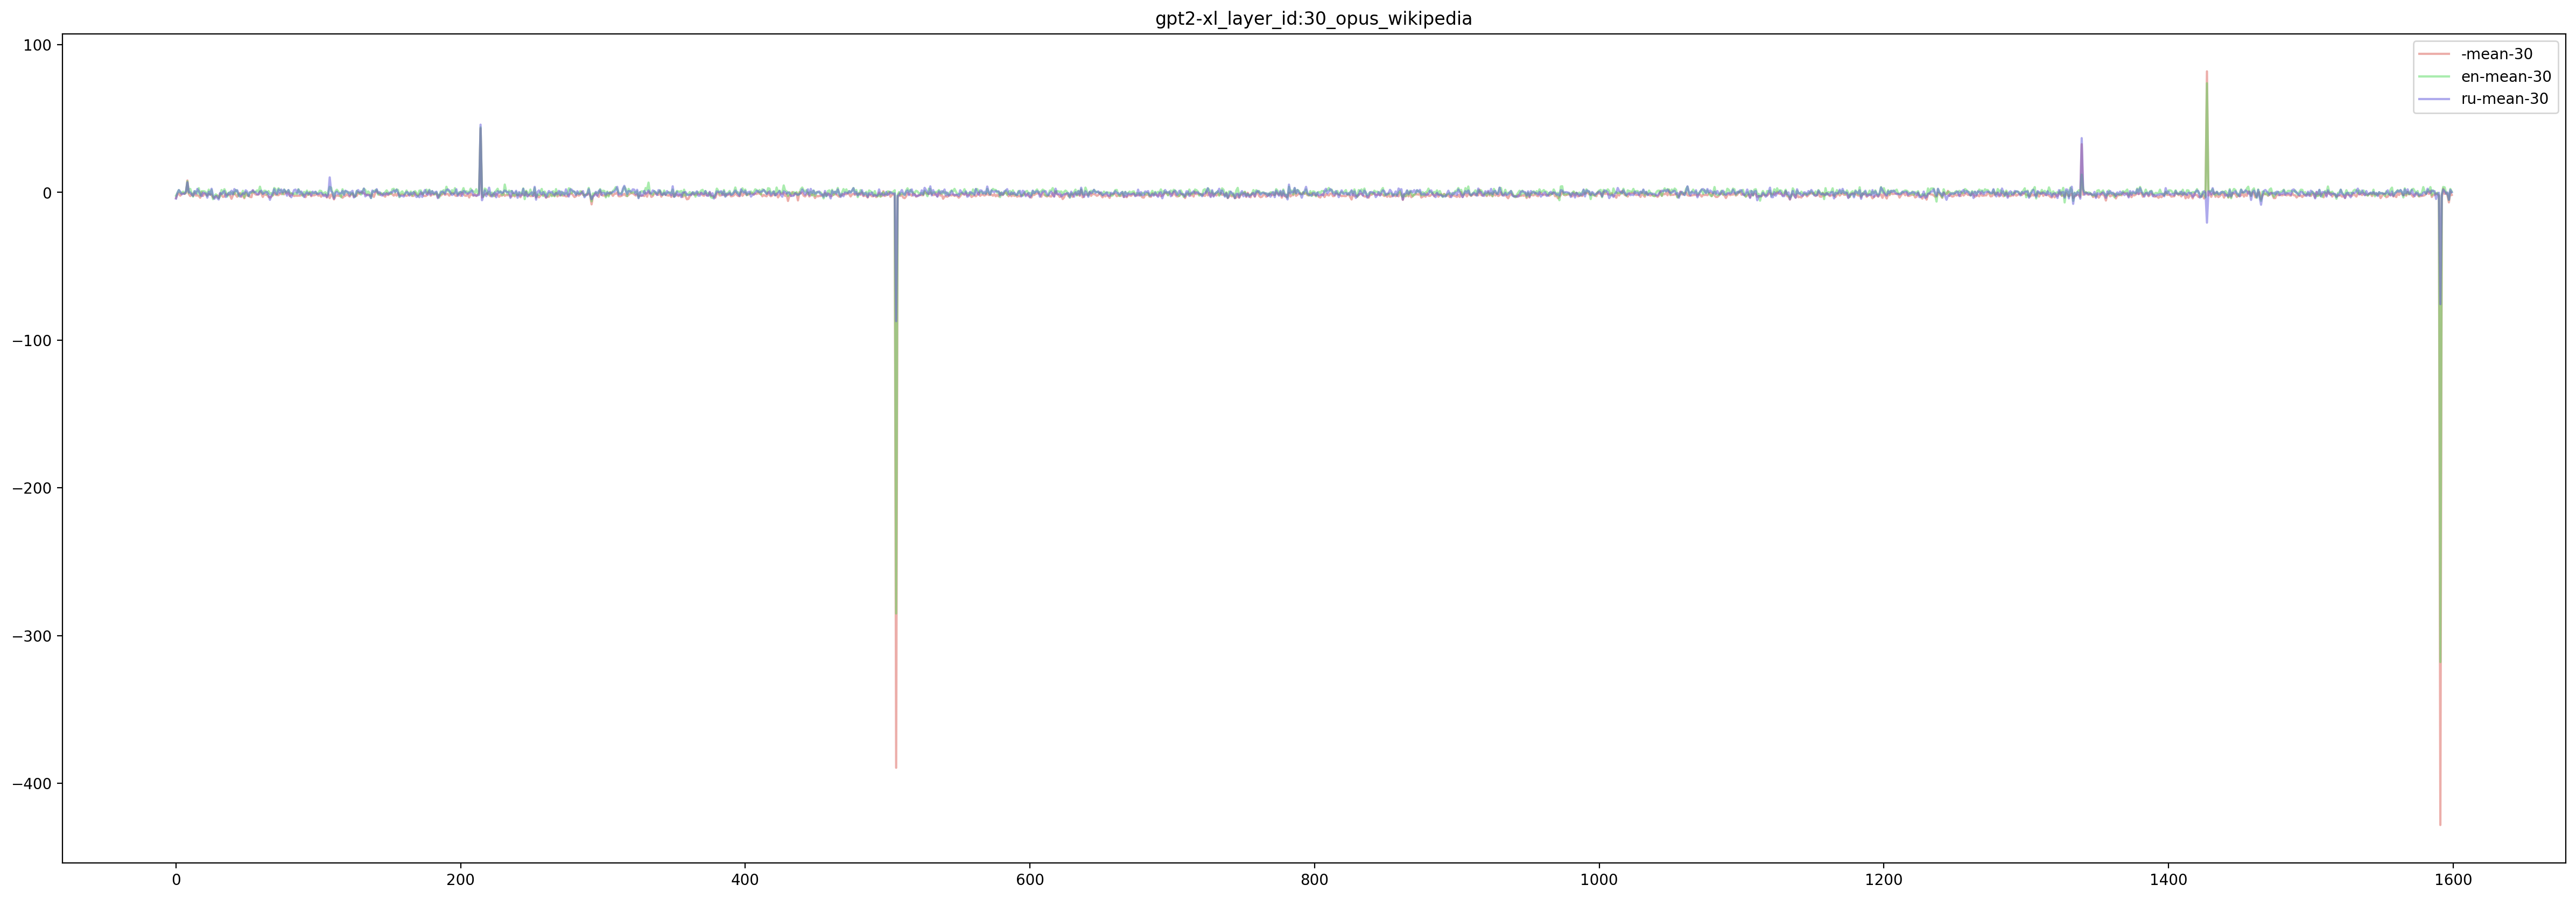

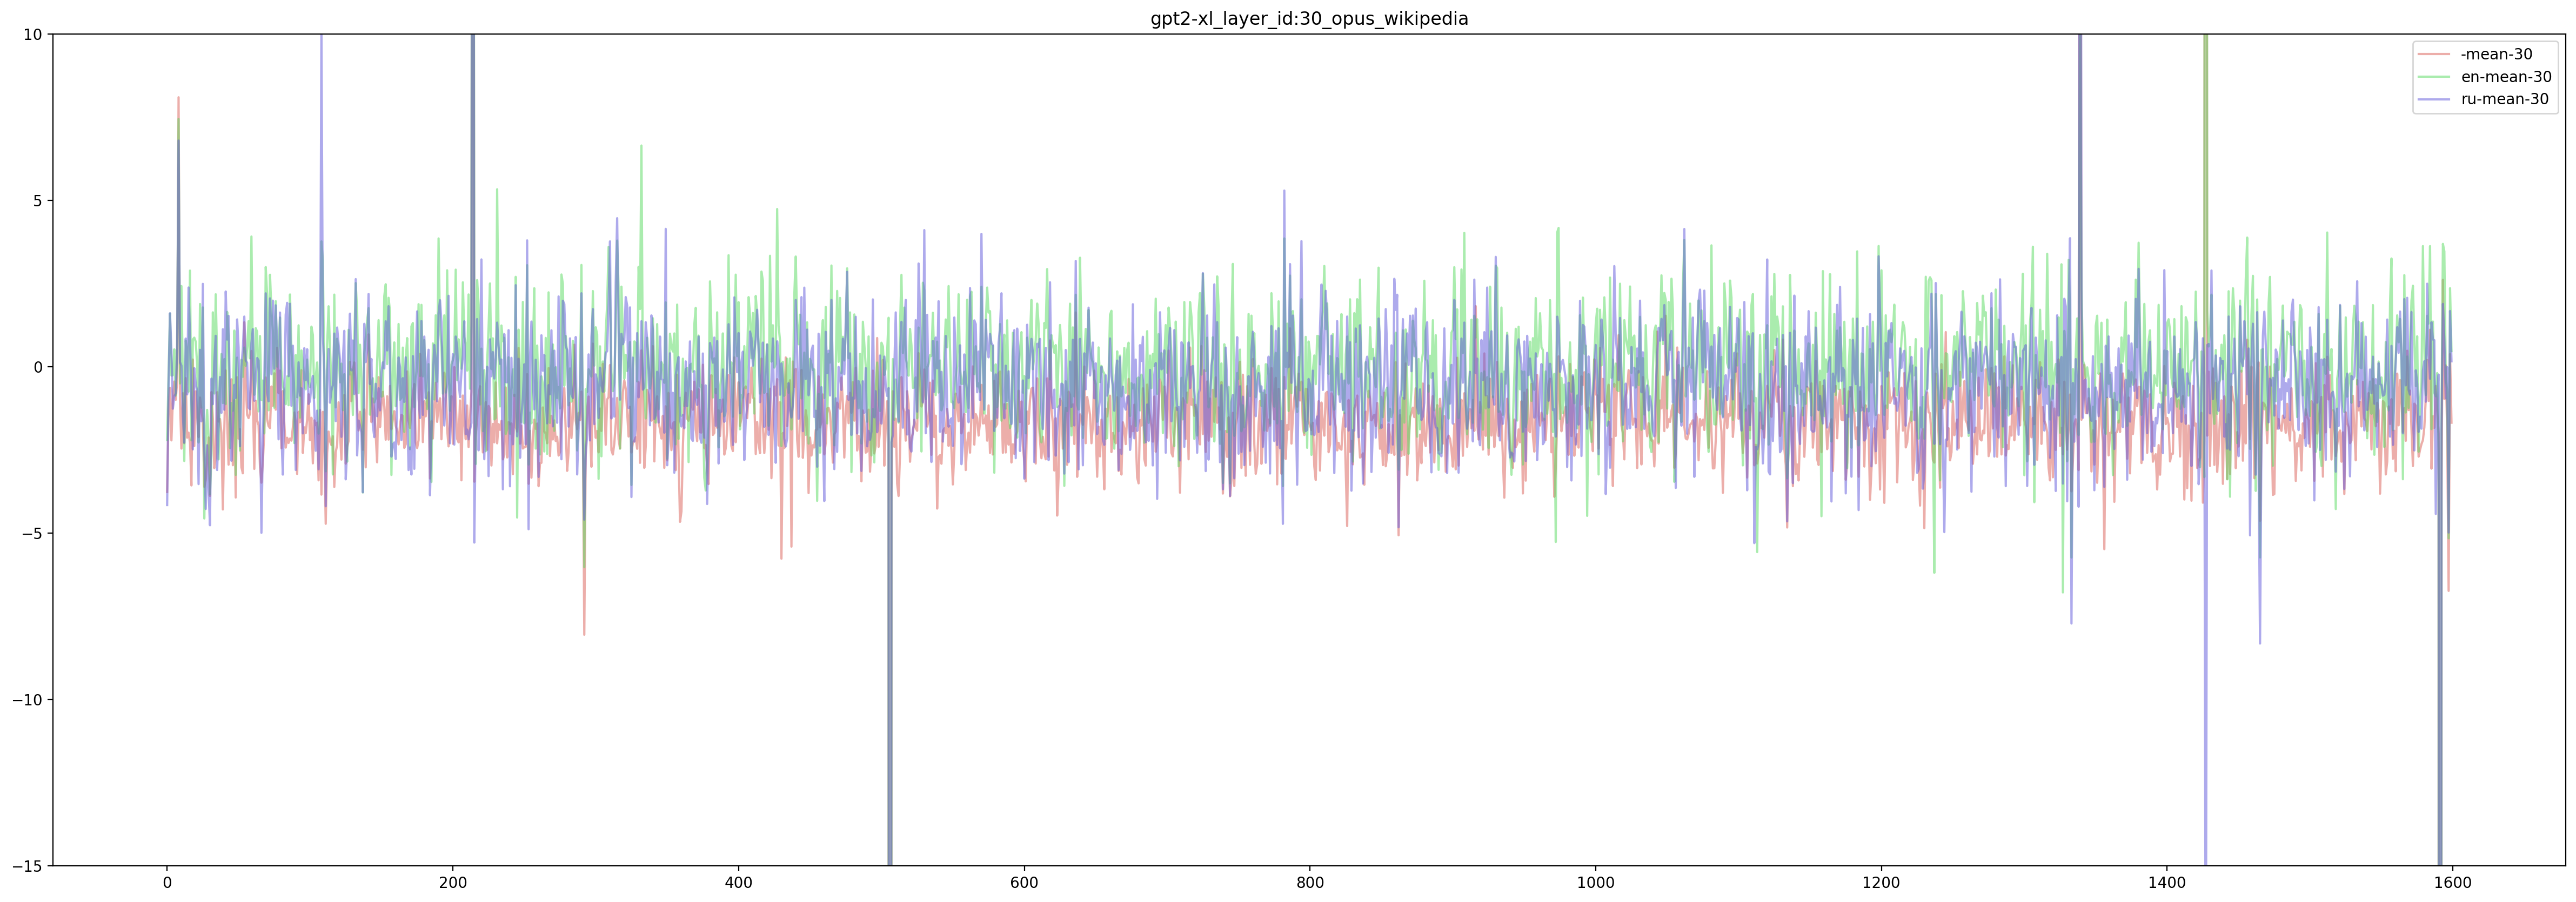

In [21]:
layer_id = 30

title = f"{model_name}_layer_id:{layer_id}_{dataset_dict[key]}"

d = module_keys[key_]
activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
# construct dataframe
data_pd = get_data_pd(d, layer_id)

x = range(unit_num)
mean_pd = data_pd.groupby(['label']).mean()
plot_line(x, mean_pd, datalabel, "mean", layer_id, None, title, dir_path, False)
# print(min_pd)
plot_line(x, mean_pd, datalabel, "mean", layer_id, [-15,10], title, dir_path, False)

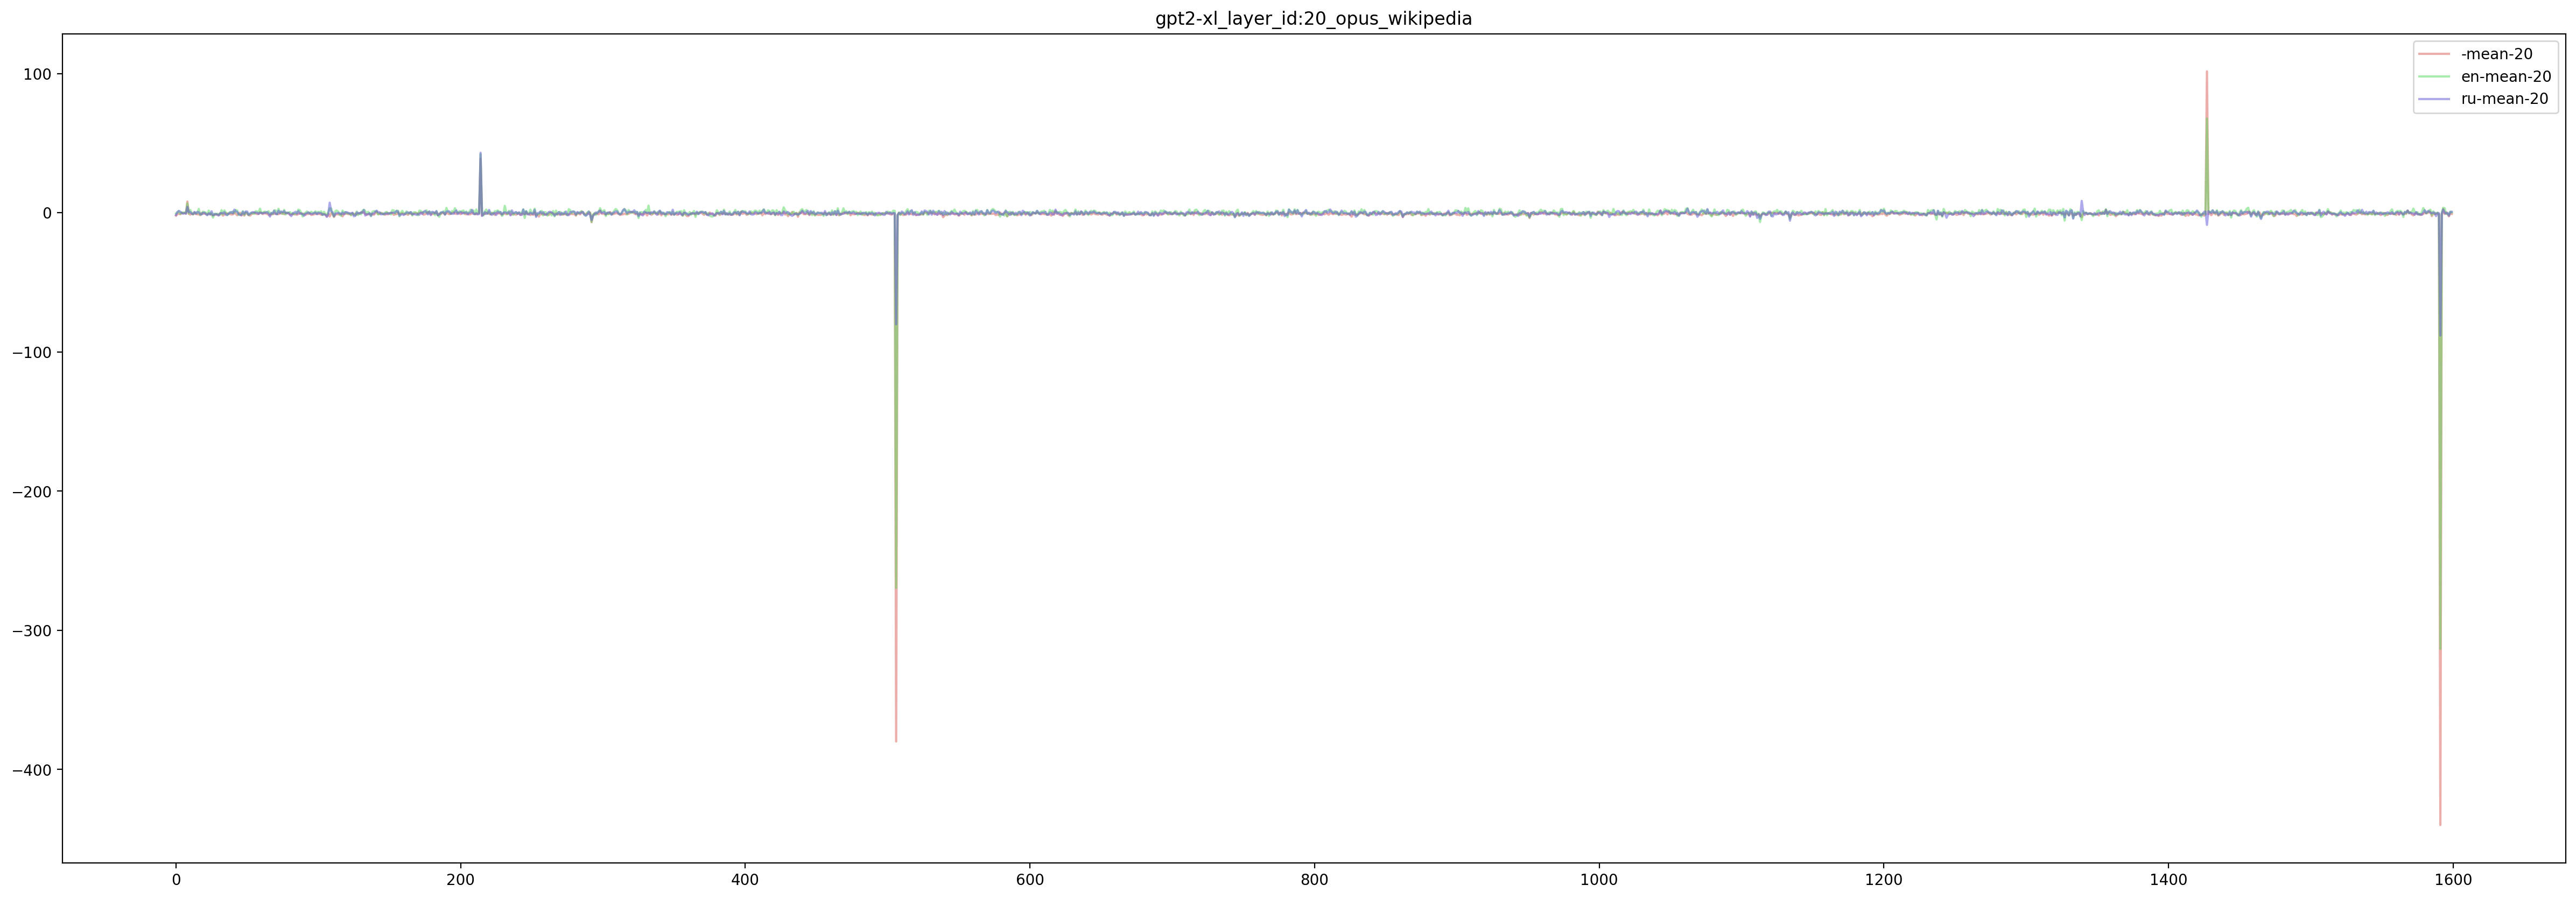

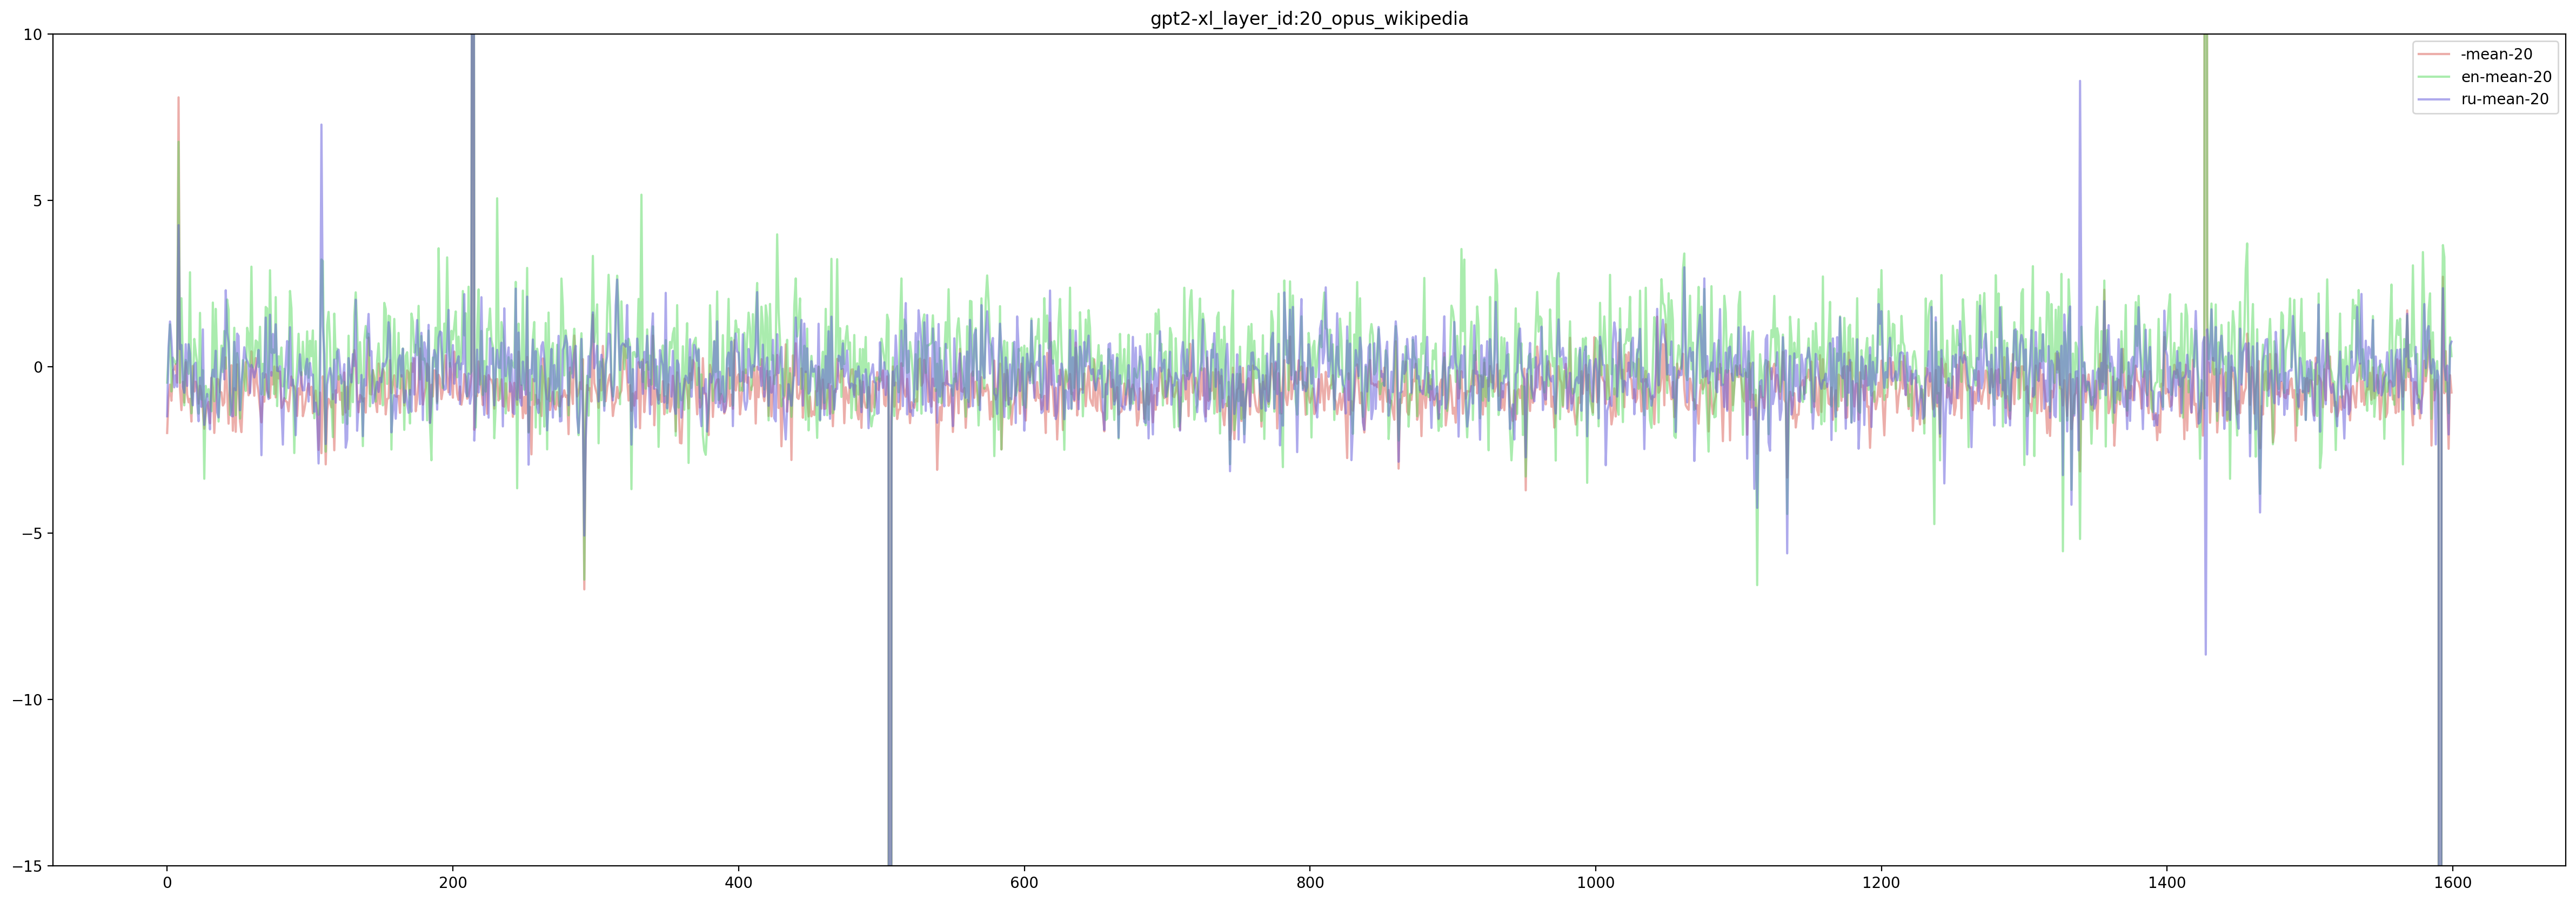

In [22]:
layer_id = 20

title = f"{model_name}_layer_id:{layer_id}_{dataset_dict[key]}"

d = module_keys[key_]
activations = torch.stack(d['activation']).cpu().numpy()[:,layer_id,:]
# construct dataframe
data_pd = get_data_pd(d, layer_id)



mean_pd = data_pd.groupby(['label']).mean()
plot_line(x, mean_pd, datalabel, "mean", layer_id, None, title, dir_path, False)
# print(min_pd)
plot_line(x, mean_pd, datalabel, "mean", layer_id, [-15,10], title, dir_path, False)